In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
experiment = '50 percent More sell LSTM Time Series - cyclic'

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image
from sklearn import preprocessing
import tensorflow_addons as tfa
import glob
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
import math

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Prepare Test Data

In [5]:
nr_test_sets = ['C6L.SI','O39.SI','0883.HK','JPM','AXL']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    labels = []
    data_15 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1
            
    X = sequential
    X  = np.array(X).reshape(-1, 15, 4)
    y = labels
    y = np.array(y)
    print(X.shape)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2019-01-21         9.59  9.538960 -32.758553  6890900.0     2.0
2019-01-22         9.63  9.552966 -25.862007  7759500.0     2.0
2019-01-23         9.61  9.561740 -29.310362  7108100.0     1.0
2019-01-24         9.50  9.552242 -48.275822  6126400.0     2.0
2019-01-25         9.74  9.581128  -8.888884  8160300.0     2.0
(218, 15, 4)
            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-21        11.75  11.523654 -10.869606  21160951.0     2.0
2019-01-22        11.73  11.555399 -13.978517  18040951.0     2.0
2019-01-23        11.50  11.546876 -38.709667  14286851.0     1.0
2019-01-24        11.38  11.521203 -51.612890   8454651.0     2.0
2019-01-25        11.41  11.504095 -80.357185  12469051.0     2.0
(218, 15, 4)
            previous_1d     EMA_12   willr_14        OBV_7  labe

In [6]:
r_test_sets = ['C6L.SI','O39.SI','0883.HK','JPM','AXL']
r_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    labels = []
    data_15 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1
            
    X = sequential
    X  = np.array(X).reshape(-1, 15, 4)
    y = labels
    y = np.array(y)
    print(X.shape)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2020-01-22         8.84  8.979182 -96.551645  -851200.0     2.0
2020-01-23         8.93  8.971615 -65.517105  1644900.0     2.0
2020-01-24         8.85  8.952905 -92.307523  -246900.0     2.0
2020-01-28         8.82  8.932458 -75.000000 -1718200.0     2.0
2020-01-29         8.56  8.875157 -86.885115 -5499900.0     2.0
(215, 15, 4)
            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2020-01-22        11.12  11.072811 -24.444379  27489400.0     2.0
2020-01-23        11.19  11.090840  -8.888884  31751200.0     2.0
2020-01-24        11.11  11.093787 -26.666653  27359800.0     2.0
2020-01-28        11.10  11.094743 -28.888715  24699300.0     2.0
2020-01-29        10.90  11.064783 -71.739257  16499235.0     2.0
(215, 15, 4)
            previous_1d     EMA_12   willr_14        OBV_7  labe

## Train Accumulation Phase Stock Data

In [7]:
def pred_acc(actual, predictions, logger):

    hold = 0
    sell = 0
    buy = 0
    pred_hold = 0
    pred_sell = 0
    pred_buy = 0
    buy_buy = 0
    buy_sell = 0
    buy_hold = 0
    sell_buy = 0
    sell_sell = 0
    sell_hold = 0
    hold_buy = 0
    hold_sell = 0
    hold_hold = 0

    for i in range (0,len(actual)):
        if actual[i]==1 and predictions[i] == 1:
            buy_buy += 1
            buy += 1
            pred_buy += 1
        elif actual[i]==1 and predictions[i] == 0:
            buy_sell += 1
            buy += 1
            pred_sell += 1
        elif actual[i]==1 and predictions[i] == 2:
            buy_hold += 1
            buy += 1
            pred_hold += 1
        elif actual[i]==0 and predictions[i] == 1:
            sell_buy += 1
            sell += 1
            pred_buy += 1
        elif actual[i]==0 and predictions[i] == 0:
            sell_sell += 1
            sell += 1
            pred_sell += 1
        elif actual[i]==0 and predictions[i] == 2:
            sell_hold += 1
            sell += 1
            pred_hold += 1
        elif actual[i]==2 and predictions[i] == 1:
            hold_buy += 1
            hold += 1
            pred_buy += 1
        elif actual[i]==2 and predictions[i] == 0:
            hold_sell += 1
            hold += 1
            pred_sell += 1
        elif actual[i]==2 and predictions[i] == 2:
            hold_hold += 1
            hold += 1
            pred_hold += 1

    print("number of predictions: " + str(len(actual)))
    print("actual predicted buys: " + str(buy_buy) )
    print("actual buys but predicted sell: " + str(buy_sell) )
    print("actual buys but predicted hold: " + str(buy_hold))
    print("actual sells but predicted buy: " + str(sell_buy) )
    print("actual predicted sells: " + str(sell_sell))
    print("actual sells but predicted hold: " + str(sell_hold) )
    print("actual holds but predicted buy: " + str(hold_buy) )
    print("actual holds but predicted sell: " + str(hold_sell))
    print("actual predicted holds: " + str(hold_hold) )
    
    if pred_buy !=0:
        Percentage_buys_correct = 100*buy_buy/pred_buy
    else:
        Percentage_buys_correct = 0
        
    if pred_sell !=0:
        Percentage_sells_correct = 100*sell_sell/pred_sell
    else:
        Percentage_sells_correct = 0
        
    if pred_hold !=0:
        Percentage_holds_correct = 100*hold_hold/pred_hold
    else:
        Percentage_holds_correct = 0

    print("Percentage buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage holds correct: " + str(Percentage_holds_correct) + "%")

    print("actual buys: " + str(buy))
    print("actual sells: " + str(sell))
    print("actual holds: " + str(hold))
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger


In [8]:
def correct_maxima_minima(predictions, price, logger):
    correct_maxima = 0 
    correct_minima = 0
    correct_hold = 0

    hold = 0
    buy = 0
    sell = 0

#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):
        if i < 4:
            prices = price[i:i+9]
            prices.sort(key = float)
#             if i == 0:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1

        else:
            prices = price[i:i+5]
            prices = prices + price[i-4:i] 
            prices.sort(key = float)
#             if i == 10:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1
                    
    if buy !=0:
        Percentage_buys_correct = 100*correct_minima/buy
    else:
        Percentage_buys_correct = 0
        
    if sell !=0:
        Percentage_sells_correct = 100*correct_maxima/sell
    else:
        Percentage_sells_correct = 0
        
    if hold !=0:
        Percentage_holds_correct = 100*correct_hold/hold
    else:
        Percentage_holds_correct = 0

    print("Percentage low buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage high sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage mid holds correct: " + str(Percentage_holds_correct) + "%")
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger

In [9]:
def profit(predictions, price, logger):
    
    price = np.array([price]).reshape(-1, 1)
    min_max_scaler = preprocessing.MinMaxScaler()
    price = min_max_scaler.fit_transform(price)
    price = price.flatten().tolist()
    price = [x + 0.01 for x in price]
    
#     avg_price = sum(price) / len(price)
#     avg_price = int(avg_price)
#     print("Avg price of stocks: " + str(avg_price))
    
#     tens = 1
#     while avg_price >= 10:
#         avg_price /= 10
#         tens += 1
    
    
#     capital = 100*pow(10,tens-1)
    capital = 100
    print("Capital: " + str(capital))
    shares = 0

    previously_buy = False
    previously_sell = False
    prev_buy_price = 0
    bought_once = False


#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):

#         if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 5 and shares!=0:
#             capital += 0.99725 * (shares*price[i])
#             shares = 0
#             print("Stop Loss Activated!\n")
#             print("Share price: $" + str(price[i]))
#             print("Shares owned at the moment: " + str(shares))
#             print("Cash capital at the moment: $" + str(capital))
#             print("\n")
#             previously_buy = False
#             previously_sell = True

        if predictions[i] == 1 and previously_buy != True:
            shares = math.floor(capital / (price[i]*1.00275))
            capital = capital - shares*price[i]*1.00275
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            prev_buy_price = price[i]*1.00275
            bought_once = True
            previously_buy = True
            previously_sell = False

        elif predictions[i] == 0 and previously_sell != True and shares!=0: #and (price[i]/prev_buy_price-1)*100 >= 2
            capital += 0.99725 * (shares*price[i])
            shares = 0
            print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            previously_buy = False
            previously_sell = True

    if shares!=0:
        capital += 0.99725 * (shares*price[i])

    print('\n')
    print("Capital at the end of test period: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100)
    
    capital = 100
    shares = 0

    shares = math.floor(capital / (price[0]*1.00275))
    capital = capital - shares*price[0]*1.00275
    capital += 0.99725 * (shares*price[-1])

    print('\n')
    print("Capital at the end of test period if Buy and Hold: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100 )
    
    return logger

### Creating Training Data and Model

            previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2000-01-21    19.000000  19.215335 -37.499990   388000.0     2.0
2000-01-24    18.400000  19.089899 -50.000000 -2311000.0     2.0
2000-01-25    18.100000  18.937607 -48.780483 -3542000.0     2.0
2000-01-26    17.700001  18.747206 -85.714237 -6261000.0     2.0
2000-01-27    17.799999  18.601482 -82.142864 -4565000.0     2.0


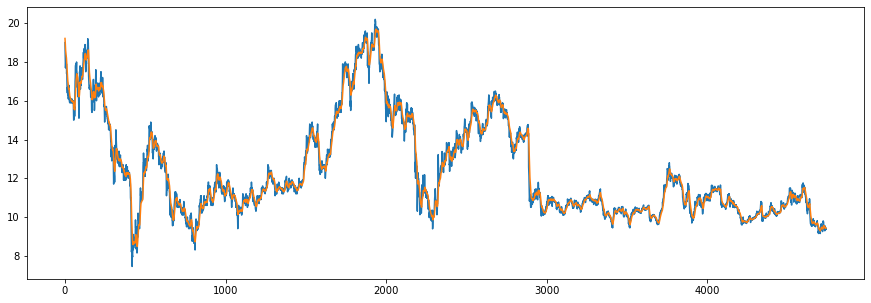

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2000-01-21     6.793788  7.018572 -90.000010 -1965914.0     2.0
2000-01-24     6.890842  6.998922 -77.777802  6276910.0     2.0
2000-01-25     6.793788  6.967363 -85.714286  -511055.0     2.0
2000-01-26     6.745261  6.933193 -86.666549 -7435027.0     2.0
2000-01-27     6.890842  6.926678 -66.666601 -3725757.0     2.0


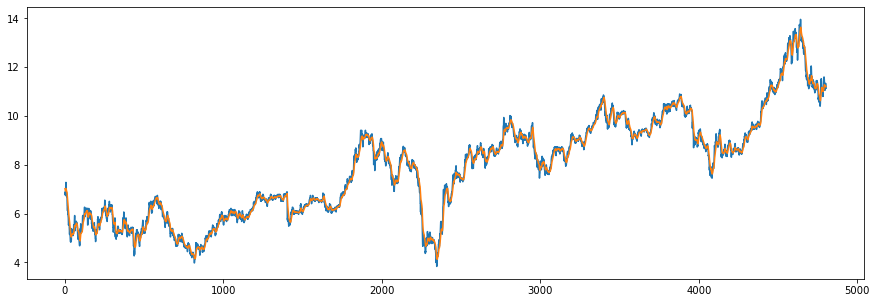

            previous_1d    EMA_12   willr_14        OBV_7  labels
Date                                                             
2000-01-24     3.189194  3.249583 -69.696967   61394527.0     2.0
2000-01-25     3.205140  3.242745 -79.136806   75032521.0     2.0
2000-01-26     3.402870  3.267380 -34.532549  127274101.0     2.0
2000-01-27     3.284870  3.270071 -62.500055   91746305.0     2.0
2000-01-28     3.252978  3.267441 -69.852957   65314909.0     2.0


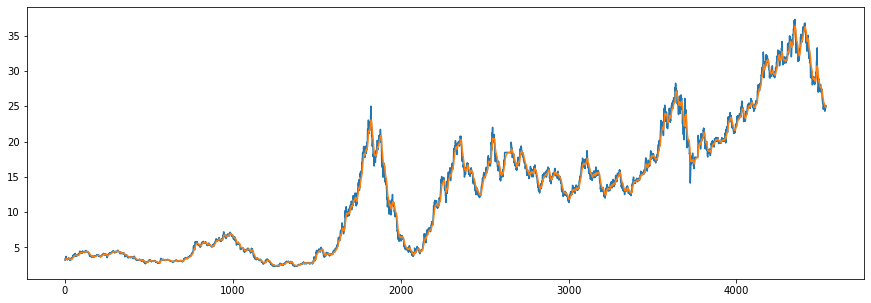

            previous_1d    EMA_12   willr_14       OBV_7  labels
Date                                                            
2004-04-07        3.250  3.264699 -57.142857  31539206.0     2.0
2004-04-08        3.200  3.254745 -78.947368 -24878594.0     2.0
2004-04-13        3.250  3.254015 -52.631579  10937473.0     0.0
2004-04-14        3.375  3.272628 -10.416706  98972973.0     2.0
2004-04-15        3.275  3.272993 -52.083331  47190715.0     2.0


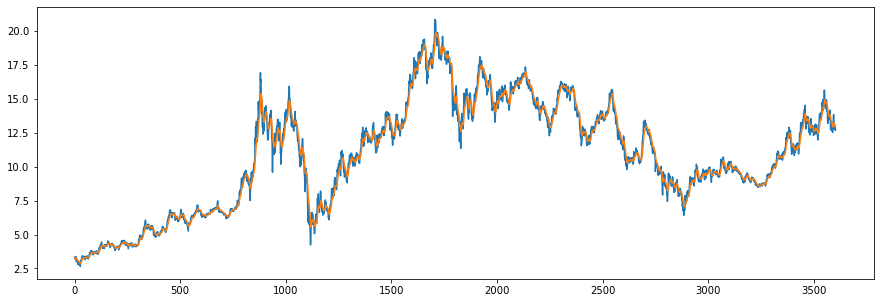

            previous_1d    EMA_12   willr_14         OBV_7  labels
Date                                                              
2006-11-17     3.953848  3.652647 -15.942120  1.897904e+10     2.0
2006-11-20     3.934226  3.695967 -18.840636  1.837444e+10     2.0
2006-11-21     3.934226  3.732622 -19.403036  1.837444e+10     2.0
2006-11-22     3.934226  3.763638 -19.697025  1.837444e+10     0.0
2006-11-23     4.051959  3.807995  -1.562480  1.907354e+10     2.0


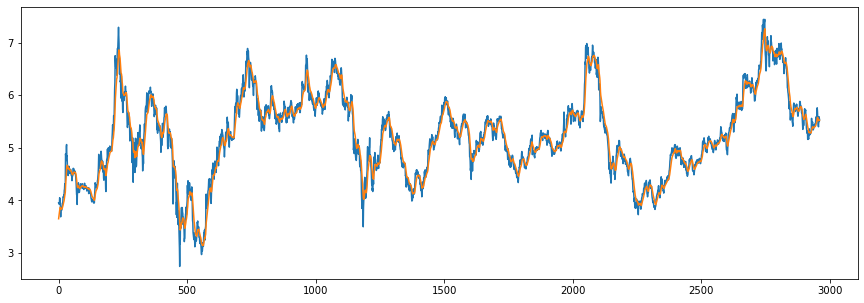

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2000-01-21      21.5000  24.211693 -82.142857  -6805500.0     2.0
2000-01-24      20.2500  23.602201 -92.465753  -8986800.0     1.0
2000-01-25      20.1875  23.076863 -92.307692 -11383100.0     2.0
2000-01-26      20.8750  22.738115 -82.786885  -9392500.0     2.0
2000-01-27      22.8750  22.759174 -56.557377  -6811000.0     2.0


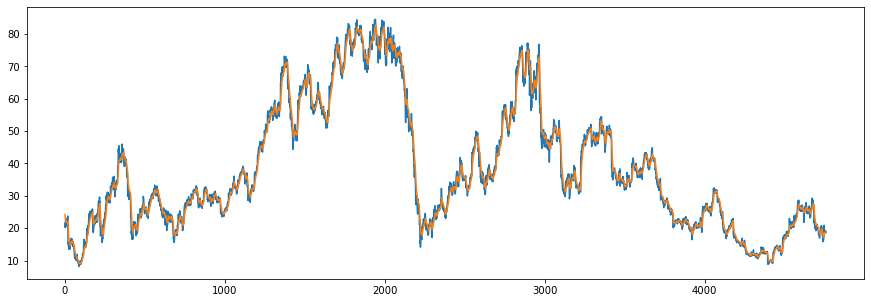

            previous_1d     EMA_12   willr_14     OBV_7  labels
Date                                                           
2000-01-21      16.0625  14.895987 -18.478261  298700.0     2.0
2000-01-24      15.8750  15.046605 -22.222222  293100.0     2.0
2000-01-25      15.7500  15.154819 -26.190476  286300.0     2.0
2000-01-26      15.7500  15.246386 -29.729730  286300.0     2.0
2000-01-27      16.0000  15.362326 -25.000000  311700.0     0.0


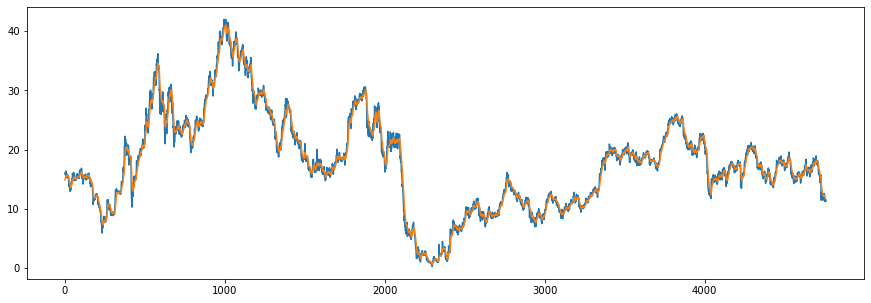

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2000-01-21    49.375000  48.388499 -42.592593  -2894250.0     2.0
2000-01-24    48.625000  48.424884 -39.516144  -8054850.0     2.0
2000-01-25    48.666668  48.462081 -38.709668  -1595700.0     2.0
2000-01-26    49.750000  48.660222 -17.741956   5984250.0     2.0
2000-01-27    52.291668  49.218906  -5.232557  14370900.0     2.0


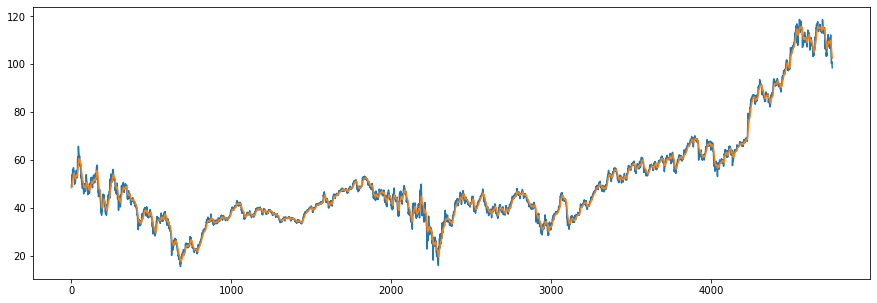

            previous_1d     EMA_12    willr_14     OBV_7  labels
Date                                                            
2000-01-21      13.7500  14.817184  -97.297297 -827200.0     2.0
2000-01-24      14.0625  14.701079  -77.500000 -518900.0     2.0
2000-01-25      13.6875  14.545144  -92.500000 -906100.0     2.0
2000-01-26      13.7500  14.422814  -90.000000 -652700.0     2.0
2000-01-27      13.5000  14.280843 -100.000000 -848400.0     2.0


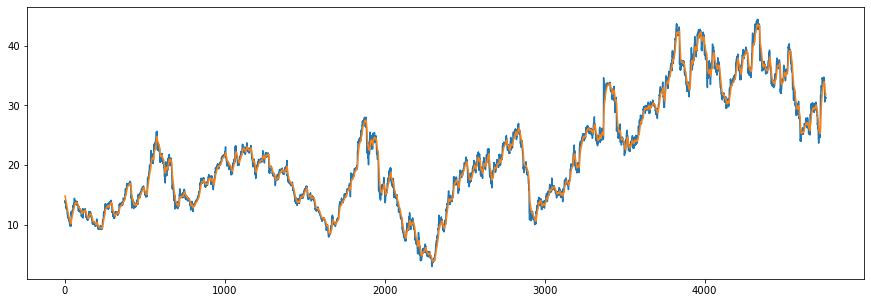

            previous_1d     EMA_12  willr_14      OBV_7  labels
Date                                                           
2010-12-21    18.799999  18.175961      -0.0  1579000.0     0.0
2010-12-22    19.000000  18.302736      -0.0  1699000.0     2.0
2010-12-23    19.000000  18.410008      -0.0  1699000.0     2.0
2010-12-27    19.000000  18.500776      -0.0  1699000.0     2.0
2010-12-28    19.000000  18.577580      -0.0  1699000.0     2.0


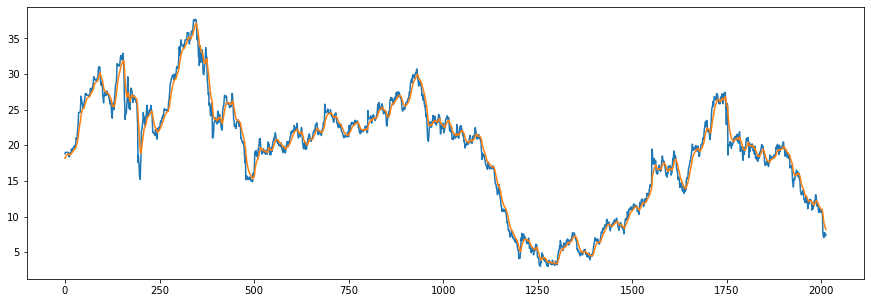

In [10]:
labels = []
sequential = []

train_sets = ['C6L.SI','O39.SI','600104.SS','0883.HK','1398.HK','ANF','AXL','JPM','CTB','TROX']

for name in train_sets:
    seed = 10
    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    plt.figure(figsize=(15,5))
    plt.plot(df['previous_1d'].values)
    plt.plot(df['EMA_12'].values)
    plt.show()

    data_15 = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1

In [11]:
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
X.shape

(41550, 15, 4)

In [12]:
y = labels
y = np.array(y)
y.shape

(41550,)

In [13]:
from collections import Counter

Counter(y)

Counter({2.0: 37853, 0.0: 1852, 1.0: 1845})

In [14]:
X = sequential
y = labels

class_0 = []
class_1 = []
class_2 = []

class_0_labels = []
class_1_labels = []
class_2_labels = []

for i in range (0,len(y)):
    if y[i] == 0:
        class_0.append(X[i])
        class_0_labels.append(y[i])
    if y[i] == 1:
        class_1.append(X[i])
        class_1_labels.append(y[i])
    if y[i] == 2:
        class_2.append(X[i])
        class_2_labels.append(y[i])
        
class_0 = class_0[0:1845]
class_1 = class_1[0:923]
class_2 = class_2[0:923]

class_0_labels = class_0_labels[0:1845]
class_1_labels = class_1_labels[0:923]
class_2_labels = class_2_labels[0:923]

X = class_0 + class_1 + class_2
y = class_0_labels + class_1_labels + class_2_labels

X  = np.array(X).reshape(-1, 15, 4)
y = np.array(y)

print(X.shape)

Counter(y)

(3691, 15, 4)


Counter({0.0: 1845, 1.0: 923, 2.0: 923})

In [15]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [16]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [17]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [19]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

epochs = 0 
histories = {}
log_hist = {}

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    nr_log  = pd.DataFrame(columns = column_names)
    r_log  = pd.DataFrame(columns = column_names)
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        callbacks=[tensorboard],
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    test_sets = ['C6L.SI','O39.SI','0883.HK','JPM','AXL']
    
    for name in test_sets:
        
        print('\n')
        print(name)
        print('\n')
        
        print('Non-Recession Test')
        print('\n')
        
        X = nr_test_data['{}_X'.format(name)]
        y = nr_test_data['{}_y'.format(name)]

        score = model.evaluate(X, y)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        print('\n')
        logger.append(score[1]) 
        
        predictions = model.predict(X)
        predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
        actual = [np.argmax(i, axis=None, out=None) for i in y]
        
        df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
        df.set_index('Date', inplace=True)
        df = df.iloc[14:]
        df['predictions'] = predictions
        df['actual'] = actual
        df['previous_1d'] = df['previous_1d'].shift(-1)
        df.dropna(inplace=True)
        
        prediction = df['predictions'].values.tolist()
        price = df['previous_1d'].values.tolist()
        
        logger = pred_acc(actual, predictions, logger)
        print('\n')
        logger = correct_maxima_minima(prediction, price, logger)
        print('\n')
        logger = profit(prediction, price, logger)
        
        df_length = len(nr_log)
        nr_log.loc[df_length] = logger
        print(nr_log.head(20))
        logger = []
        
        print('Recession Test')
        print('\n')
        
        X = r_test_data['{}_X'.format(name)]
        y = r_test_data['{}_y'.format(name)]

        score = model.evaluate(X, y)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        print('\n')
        logger.append(score[1]) 
        
        predictions = model.predict(X)
        predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
        actual = [np.argmax(i, axis=None, out=None) for i in y]
        
        df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format(name))
        df.set_index('Date', inplace=True)
        df = df.iloc[14:]
        df['predictions'] = predictions
        df['actual'] = actual
        df['previous_1d'] = df['previous_1d'].shift(-1)
        df.dropna(inplace=True)
        
        prediction = df['predictions'].values.tolist()
        price = df['previous_1d'].values.tolist()
        
        logger = pred_acc(actual, predictions, logger)
        print('\n')
        logger = correct_maxima_minima(prediction, price, logger)
        print('\n')
        logger = profit(prediction, price, logger)
        
        df_length = len(r_log)
        r_log.loc[df_length] = logger
        print(r_log.head(20))
        logger = []

    nr_log.to_csv('non_recession_{}_{}epochs.csv'.format(experiment,epochs))
    nr_log_hist['{}_epochs_logs'.format(epochs)] = nr_log
    r_log.to_csv('recession_{}_{}epochs.csv'.format(experiment,epochs))
    r_log_hist['{}_epochs_logs'.format(epochs)] = r_log
    epochs = epochs + 20

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[1 2 1 ... 0 2 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "





RUNNING EPOCHS 0 - 20



Epoch 1/20
 1/24 [>.............................] - ETA: 0s - loss: 0.3704 - accuracy: 0.2422 - mse: 0.4861 - weighted_accuracy: 0.3026 - weighted_mse: 0.4517WARNING:tensorflow:From C:\Users\Shearman Chua\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
24/24 [==============================] - 1s 42ms/step - loss: 0.2866 - accuracy: 0.2815 - mse: 0.5456 - weighted_accuracy: 0.3372 - weighted_mse: 0.5261 - val_loss: 0.2988 - val_accuracy: 0.2991 - val_mse: 0.3480 - val_weighted_accuracy: 0.2991 - val_weighted_mse: 0.3480
Epoch 2/20
24/24 [==============================] - 0s 9ms/step - loss: 0.2063 - accuracy: 0.4749 - mse: 0.7664 - weighted_accuracy: 0.4682 - weighted_mse: 0.7736 - val_loss: 0.2919 - val_accuracy: 0.2503 - val_mse: 0.3688 - val_weighted_accuracy: 0.25

7/7 [==============================] - 0s 3ms/step - loss: 0.1736 - accuracy: 0.4651 - mse: 1.2360 - weighted_accuracy: 0.4651 - weighted_mse: 1.2360
Test loss: 0.1736295074224472
Test accuracy: 0.4651162922382355


number of predictions: 215
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 2
actual predicted sells: 2
actual sells but predicted hold: 5
actual holds but predicted buy: 78
actual holds but predicted sell: 28
actual predicted holds: 92
Percentage buys correct: 6.976744186046512%
Percentage sells correct: 6.666666666666667%
Percentage holds correct: 92.92929292929293%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 45.348837209302324%
Percentage high sells correct: 56.666666666666664%
Percentage mid holds correct: 88.77551020408163%


Capital: 100
Share price: $0.9763550825449694
Shares owned at the moment: 102
Cash capital at the moment: $0.13791397975924724


Price 

7/7 [==============================] - 0s 3ms/step - loss: 0.1777 - accuracy: 0.4408 - mse: 1.2261 - weighted_accuracy: 0.4408 - weighted_mse: 1.2261
Test loss: 0.1776692122220993
Test accuracy: 0.44075828790664673


number of predictions: 211
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 8
actual holds but predicted buy: 75
actual holds but predicted sell: 31
actual predicted holds: 88
Percentage buys correct: 5.063291139240507%
Percentage sells correct: 3.125%
Percentage holds correct: 88.0%
actual buys: 8
actual sells: 9
actual holds: 194


Percentage low buys correct: 53.164556962025316%
Percentage high sells correct: 61.29032258064516%
Percentage mid holds correct: 77.0%


Capital: 100
Share price: $0.6685367101774722
Shares owned at the moment: 149
Cash capital at the moment: $0.11409726656142993


Price increase from previously bought: 38.29

7/7 [==============================] - 0s 3ms/step - loss: 0.1701 - accuracy: 0.5662 - mse: 1.1931 - weighted_accuracy: 0.5662 - weighted_mse: 1.1931
Test loss: 0.17014481127262115
Test accuracy: 0.5662100315093994


number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 2
actual predicted sells: 3
actual sells but predicted hold: 7
actual holds but predicted buy: 52
actual holds but predicted sell: 27
actual predicted holds: 118
Percentage buys correct: 5.2631578947368425%
Percentage sells correct: 10.0%
Percentage holds correct: 89.39393939393939%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 47.36842105263158%
Percentage high sells correct: 56.666666666666664%
Percentage mid holds correct: 82.44274809160305%


Capital: 100
Share price: $0.9699796411480657
Shares owned at the moment: 102
Cash capital at the moment: $0.7899973135552756


Price increase f

7/7 [==============================] - 0s 3ms/step - loss: 0.1685 - accuracy: 0.5616 - mse: 1.1933 - weighted_accuracy: 0.5616 - weighted_mse: 1.1933
Test loss: 0.16851076483726501
Test accuracy: 0.5616438388824463


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 1
actual predicted sells: 2
actual sells but predicted hold: 8
actual holds but predicted buy: 57
actual holds but predicted sell: 24
actual predicted holds: 116
Percentage buys correct: 7.936507936507937%
Percentage sells correct: 7.6923076923076925%
Percentage holds correct: 89.23076923076923%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 53.96825396825397%
Percentage high sells correct: 57.69230769230769%
Percentage mid holds correct: 82.94573643410853%


Capital: 100
Share price: $0.6915789433232307
Shares owned at the moment: 144
Cash capital at the moment: $0.13876689989878344


Pri

Epoch 14/20
24/24 [==============================] - 0s 9ms/step - loss: 0.1301 - accuracy: 0.7398 - mse: 1.6487 - weighted_accuracy: 0.7175 - weighted_mse: 1.6449 - val_loss: 0.1423 - val_accuracy: 0.6576 - val_mse: 1.5409 - val_weighted_accuracy: 0.6576 - val_weighted_mse: 1.5409
Epoch 15/20
24/24 [==============================] - 0s 8ms/step - loss: 0.1291 - accuracy: 0.7381 - mse: 1.6520 - weighted_accuracy: 0.7152 - weighted_mse: 1.6474 - val_loss: 0.1372 - val_accuracy: 0.6806 - val_mse: 1.6346 - val_weighted_accuracy: 0.6806 - val_weighted_mse: 1.6346
Epoch 16/20
24/24 [==============================] - 0s 8ms/step - loss: 0.1278 - accuracy: 0.7405 - mse: 1.6707 - weighted_accuracy: 0.7206 - weighted_mse: 1.6674 - val_loss: 0.1394 - val_accuracy: 0.6698 - val_mse: 1.7362 - val_weighted_accuracy: 0.6698 - val_weighted_mse: 1.7362
Epoch 17/20
24/24 [==============================] - 0s 8ms/step - loss: 0.1275 - accuracy: 0.7436 - mse: 1.6725 - weighted_accuracy: 0.7191 - weighted

7/7 [==============================] - 0s 3ms/step - loss: 0.2687 - accuracy: 0.2791 - mse: 2.0243 - weighted_accuracy: 0.2791 - weighted_mse: 2.0243
Test loss: 0.26865875720977783
Test accuracy: 0.27906978130340576


number of predictions: 215
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 2
actual predicted sells: 7
actual sells but predicted hold: 0
actual holds but predicted buy: 96
actual holds but predicted sell: 56
actual predicted holds: 46
Percentage buys correct: 6.666666666666667%
Percentage sells correct: 11.11111111111111%
Percentage holds correct: 97.87234042553192%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 48.57142857142857%
Percentage high sells correct: 62.903225806451616%
Percentage mid holds correct: 97.87234042553192%


Capital: 100
Share price: $1.0062617748699323
Shares owned at the moment: 99
Cash capital at the moment: $0.10612951966835737


Price 

7/7 [==============================] - 0s 3ms/step - loss: 0.2928 - accuracy: 0.2279 - mse: 2.0749 - weighted_accuracy: 0.2279 - weighted_mse: 2.0749
Test loss: 0.2927705645561218
Test accuracy: 0.2279069721698761


number of predictions: 215
actual predicted buys: 9
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 2
actual predicted sells: 7
actual sells but predicted hold: 1
actual holds but predicted buy: 88
actual holds but predicted sell: 72
actual predicted holds: 33
Percentage buys correct: 9.090909090909092%
Percentage sells correct: 8.860759493670885%
Percentage holds correct: 89.1891891891892%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 53.535353535353536%
Percentage high sells correct: 60.256410256410255%
Percentage mid holds correct: 81.08108108108108%


Capital: 100
Share price: $0.9886586309918834
Shares owned at the moment: 100
Cash capital at the moment: $0.8622557772888797


Price 

7/7 [==============================] - 0s 3ms/step - loss: 0.2329 - accuracy: 0.3474 - mse: 1.9133 - weighted_accuracy: 0.3474 - weighted_mse: 1.9133
Test loss: 0.23292304575443268
Test accuracy: 0.34741783142089844


number of predictions: 213
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 2
actual sells but predicted buy: 2
actual predicted sells: 5
actual sells but predicted hold: 3
actual holds but predicted buy: 91
actual holds but predicted sell: 40
actual predicted holds: 62
Percentage buys correct: 7.0%
Percentage sells correct: 10.869565217391305%
Percentage holds correct: 92.53731343283582%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 45.0%
Percentage high sells correct: 60.0%
Percentage mid holds correct: 86.56716417910448%


Capital: 100
Share price: $0.9662289181183106
Shares owned at the moment: 103
Cash capital at the moment: $0.20473709275698582


Price increase from previously bought: -78.

7/7 [==============================] - 0s 3ms/step - loss: 0.2626 - accuracy: 0.2877 - mse: 1.9131 - weighted_accuracy: 0.2877 - weighted_mse: 1.9131
Test loss: 0.26263922452926636
Test accuracy: 0.2876712381839752


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 10
actual sells but predicted hold: 1
actual holds but predicted buy: 81
actual holds but predicted sell: 71
actual predicted holds: 45
Percentage buys correct: 8.88888888888889%
Percentage sells correct: 12.345679012345679%
Percentage holds correct: 93.75%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 43.82022471910113%
Percentage high sells correct: 58.02469135802469%
Percentage mid holds correct: 87.5%


Capital: 100
Share price: $1.0008429154662593
Shares owned at the moment: 99
Cash capital at the moment: $0.644071885104637


Price increase from previously b

4         -40.196200  
Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.2639 - accuracy: 0.2694 - mse: 1.9442 - weighted_accuracy: 0.2694 - weighted_mse: 1.9442
Test loss: 0.2638642489910126
Test accuracy: 0.26940637826919556


number of predictions: 219
actual predicted buys: 11
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 4
actual holds but predicted buy: 73
actual holds but predicted sell: 82
actual predicted holds: 42
Percentage buys correct: 12.941176470588236%
Percentage sells correct: 6.818181818181818%
Percentage holds correct: 91.30434782608695%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 61.904761904761905%
Percentage high sells correct: 57.95454545454545%
Percentage mid holds correct: 84.78260869565217%


Capital: 100
Share price: $0.7376316242287357
Shares owned at the moment: 135
Cash capital 

Epoch 6/20
24/24 [==============================] - 0s 8ms/step - loss: 0.1216 - accuracy: 0.7547 - mse: 1.8123 - weighted_accuracy: 0.7376 - weighted_mse: 1.7979 - val_loss: 0.1374 - val_accuracy: 0.6685 - val_mse: 1.9552 - val_weighted_accuracy: 0.6685 - val_weighted_mse: 1.9552
Epoch 7/20
24/24 [==============================] - 0s 8ms/step - loss: 0.1204 - accuracy: 0.7544 - mse: 1.8132 - weighted_accuracy: 0.7398 - weighted_mse: 1.7966 - val_loss: 0.1384 - val_accuracy: 0.6631 - val_mse: 1.9303 - val_weighted_accuracy: 0.6631 - val_weighted_mse: 1.9303
Epoch 8/20
24/24 [==============================] - 0s 8ms/step - loss: 0.1193 - accuracy: 0.7676 - mse: 1.8279 - weighted_accuracy: 0.7489 - weighted_mse: 1.8108 - val_loss: 0.1379 - val_accuracy: 0.6752 - val_mse: 1.9852 - val_weighted_accuracy: 0.6752 - val_weighted_mse: 1.9852
Epoch 9/20
24/24 [==============================] - 0s 7ms/step - loss: 0.1202 - accuracy: 0.7554 - mse: 1.8349 - weighted_accuracy: 0.7394 - weighted_mse

7/7 [==============================] - 0s 3ms/step - loss: 0.3188 - accuracy: 0.2605 - mse: 2.4529 - weighted_accuracy: 0.2605 - weighted_mse: 2.4529
Test loss: 0.3187858462333679
Test accuracy: 0.2604651153087616


number of predictions: 215
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 1
actual holds but predicted buy: 97
actual holds but predicted sell: 59
actual predicted holds: 42
Percentage buys correct: 6.666666666666667%
Percentage sells correct: 10.606060606060606%
Percentage holds correct: 95.45454545454545%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 49.523809523809526%
Percentage high sells correct: 61.53846153846154%
Percentage mid holds correct: 95.45454545454545%


Capital: 100
Share price: $1.0062617748699323
Shares owned at the moment: 99
Cash capital at the moment: $0.10612951966835737


Price i

7/7 [==============================] - 0s 3ms/step - loss: 0.3351 - accuracy: 0.2465 - mse: 2.4181 - weighted_accuracy: 0.2465 - weighted_mse: 2.4181
Test loss: 0.3350936472415924
Test accuracy: 0.24651162326335907


number of predictions: 215
actual predicted buys: 9
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 2
actual predicted sells: 8
actual sells but predicted hold: 0
actual holds but predicted buy: 87
actual holds but predicted sell: 70
actual predicted holds: 36
Percentage buys correct: 9.183673469387756%
Percentage sells correct: 10.256410256410257%
Percentage holds correct: 92.3076923076923%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 54.08163265306123%
Percentage high sells correct: 62.33766233766234%
Percentage mid holds correct: 87.17948717948718%


Capital: 100
Share price: $0.9886586309918834
Shares owned at the moment: 100
Cash capital at the moment: $0.8622557772888797


Price 

7/7 [==============================] - 0s 3ms/step - loss: 0.2594 - accuracy: 0.3521 - mse: 2.2135 - weighted_accuracy: 0.3521 - weighted_mse: 2.2135
Test loss: 0.25944262742996216
Test accuracy: 0.35211268067359924


number of predictions: 213
actual predicted buys: 8
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 2
actual predicted sells: 5
actual sells but predicted hold: 3
actual holds but predicted buy: 89
actual holds but predicted sell: 42
actual predicted holds: 62
Percentage buys correct: 8.080808080808081%
Percentage sells correct: 10.416666666666666%
Percentage holds correct: 93.93939393939394%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 48.484848484848484%
Percentage high sells correct: 61.702127659574465%
Percentage mid holds correct: 86.36363636363636%


Capital: 100
Share price: $0.9662289181183106
Shares owned at the moment: 103
Cash capital at the moment: $0.20473709275698582


P

7/7 [==============================] - 0s 3ms/step - loss: 0.3062 - accuracy: 0.3151 - mse: 2.2504 - weighted_accuracy: 0.3151 - weighted_mse: 2.2504
Test loss: 0.30617794394493103
Test accuracy: 0.31506848335266113


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 9
actual sells but predicted hold: 2
actual holds but predicted buy: 81
actual holds but predicted sell: 64
actual predicted holds: 52
Percentage buys correct: 8.88888888888889%
Percentage sells correct: 12.32876712328767%
Percentage holds correct: 92.85714285714286%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 48.31460674157304%
Percentage high sells correct: 58.9041095890411%
Percentage mid holds correct: 89.28571428571429%


Capital: 100
Share price: $1.0008429154662593
Shares owned at the moment: 99
Cash capital at the moment: $0.644071885104637


Price inc

Price increase from previously bought: 1.2193529348202725%
Share price: $0.5585347737425168
Shares owned at the moment: 0
Cash capital at the moment: $60.899242573152065


Share price: $0.5649450021614875
Shares owned at the moment: 107
Cash capital at the moment: $0.28389227498688996


Price increase from previously bought: -89.50561475077508%
Share price: $0.05945054561174445
Shares owned at the moment: 0
Cash capital at the moment: $6.6276073323972895


Share price: $0.0420512730940703
Shares owned at the moment: 157
Cash capital at the moment: $0.007401819469887272


Price increase from previously bought: -76.2847241383333%
Share price: $0.01
Shares owned at the moment: 0
Cash capital at the moment: $1.5730843194698874


Share price: $0.03747250108074362
Shares owned at the moment: 41
Cash capital at the moment: $0.03248675066254525


Price increase from previously bought: 467.64741006540953%
Share price: $0.21329663899672058
Shares owned at the moment: 0
Cash capital at the moment

Epoch 1/20
24/24 [==============================] - 0s 13ms/step - loss: 0.1122 - accuracy: 0.7829 - mse: 1.9979 - weighted_accuracy: 0.7699 - weighted_mse: 1.9761 - val_loss: 0.1373 - val_accuracy: 0.6834 - val_mse: 2.0618 - val_weighted_accuracy: 0.6834 - val_weighted_mse: 2.0618
Epoch 2/20
24/24 [==============================] - 0s 9ms/step - loss: 0.1107 - accuracy: 0.7869 - mse: 1.9750 - weighted_accuracy: 0.7717 - weighted_mse: 1.9495 - val_loss: 0.1418 - val_accuracy: 0.6779 - val_mse: 2.1781 - val_weighted_accuracy: 0.6779 - val_weighted_mse: 2.1781
Epoch 3/20
24/24 [==============================] - 0s 8ms/step - loss: 0.1110 - accuracy: 0.7781 - mse: 2.0120 - weighted_accuracy: 0.7694 - weighted_mse: 1.9929 - val_loss: 0.1411 - val_accuracy: 0.6712 - val_mse: 2.1191 - val_weighted_accuracy: 0.6712 - val_weighted_mse: 2.1191
Epoch 4/20
24/24 [==============================] - 0s 8ms/step - loss: 0.1097 - accuracy: 0.7873 - mse: 2.0158 - weighted_accuracy: 0.7751 - weighted_ms

7/7 [==============================] - 0s 3ms/step - loss: 0.3595 - accuracy: 0.2698 - mse: 2.8257 - weighted_accuracy: 0.2698 - weighted_mse: 2.8257
Test loss: 0.3594978153705597
Test accuracy: 0.2697674334049225


number of predictions: 215
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 0
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 87
actual holds but predicted sell: 67
actual predicted holds: 44
Percentage buys correct: 7.446808510638298%
Percentage sells correct: 9.333333333333334%
Percentage holds correct: 95.65217391304348%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 52.12765957446808%
Percentage high sells correct: 58.108108108108105%
Percentage mid holds correct: 95.65217391304348%


Capital: 100
Share price: $1.0062617748699323
Shares owned at the moment: 99
Cash capital at the moment: $0.10612951966835737


Price in

7/7 [==============================] - 0s 3ms/step - loss: 0.3817 - accuracy: 0.2605 - mse: 2.8036 - weighted_accuracy: 0.2605 - weighted_mse: 2.8036
Test loss: 0.38167819380760193
Test accuracy: 0.2604651153087616


number of predictions: 215
actual predicted buys: 8
actual buys but predicted sell: 1
actual buys but predicted hold: 3
actual sells but predicted buy: 2
actual predicted sells: 8
actual sells but predicted hold: 0
actual holds but predicted buy: 78
actual holds but predicted sell: 75
actual predicted holds: 40
Percentage buys correct: 9.090909090909092%
Percentage sells correct: 9.523809523809524%
Percentage holds correct: 93.02325581395348%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 54.54545454545455%
Percentage high sells correct: 60.24096385542169%
Percentage mid holds correct: 90.69767441860465%


Capital: 100
Share price: $0.9886586309918834
Shares owned at the moment: 100
Cash capital at the moment: $0.8622557772888797


Price 

7/7 [==============================] - 0s 3ms/step - loss: 0.2860 - accuracy: 0.3333 - mse: 2.5319 - weighted_accuracy: 0.3333 - weighted_mse: 2.5319
Test loss: 0.2859891355037689
Test accuracy: 0.3333333432674408


number of predictions: 213
actual predicted buys: 7
actual buys but predicted sell: 2
actual buys but predicted hold: 1
actual sells but predicted buy: 3
actual predicted sells: 5
actual sells but predicted hold: 2
actual holds but predicted buy: 79
actual holds but predicted sell: 55
actual predicted holds: 59
Percentage buys correct: 7.865168539325842%
Percentage sells correct: 8.064516129032258%
Percentage holds correct: 95.16129032258064%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 46.06741573033708%
Percentage high sells correct: 57.377049180327866%
Percentage mid holds correct: 85.48387096774194%


Capital: 100
Share price: $0.9662289181183106
Shares owned at the moment: 103
Cash capital at the moment: $0.20473709275698582


Price

7/7 [==============================] - 0s 3ms/step - loss: 0.3454 - accuracy: 0.3288 - mse: 2.5913 - weighted_accuracy: 0.3288 - weighted_mse: 2.5913
Test loss: 0.34541118144989014
Test accuracy: 0.3287671208381653


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 1
actual predicted sells: 9
actual sells but predicted hold: 2
actual holds but predicted buy: 72
actual holds but predicted sell: 68
actual predicted holds: 57
Percentage buys correct: 7.594936708860759%
Percentage sells correct: 11.688311688311689%
Percentage holds correct: 90.47619047619048%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 51.282051282051285%
Percentage high sells correct: 62.33766233766234%
Percentage mid holds correct: 87.3015873015873%


Capital: 100
Share price: $0.9699796411480657
Shares owned at the moment: 102
Cash capital at the moment: $0.7899973135552756


Price

7/7 [==============================] - 0s 3ms/step - loss: 0.3518 - accuracy: 0.2511 - mse: 2.5714 - weighted_accuracy: 0.2511 - weighted_mse: 2.5714
Test loss: 0.3517945110797882
Test accuracy: 0.2511415481567383


number of predictions: 219
actual predicted buys: 9
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 0
actual predicted sells: 7
actual sells but predicted hold: 4
actual holds but predicted buy: 65
actual holds but predicted sell: 93
actual predicted holds: 39
Percentage buys correct: 12.162162162162161%
Percentage sells correct: 7.0%
Percentage holds correct: 86.66666666666667%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 58.9041095890411%
Percentage high sells correct: 56.0%
Percentage mid holds correct: 82.22222222222223%


Capital: 100
Share price: $0.7376316242287357
Shares owned at the moment: 135
Cash capital at the moment: $0.1458849886257525


Price increase from previously bou

Epoch 7/20
24/24 [==============================] - 0s 8ms/step - loss: 0.0966 - accuracy: 0.8157 - mse: 2.3197 - weighted_accuracy: 0.8119 - weighted_mse: 2.2739 - val_loss: 0.1450 - val_accuracy: 0.6752 - val_mse: 2.5387 - val_weighted_accuracy: 0.6752 - val_weighted_mse: 2.5387
Epoch 8/20
24/24 [==============================] - 0s 8ms/step - loss: 0.0953 - accuracy: 0.8327 - mse: 2.3685 - weighted_accuracy: 0.8259 - weighted_mse: 2.3220 - val_loss: 0.1414 - val_accuracy: 0.6888 - val_mse: 2.5955 - val_weighted_accuracy: 0.6888 - val_weighted_mse: 2.5955
Epoch 9/20
24/24 [==============================] - 0s 8ms/step - loss: 0.0956 - accuracy: 0.8259 - mse: 2.3540 - weighted_accuracy: 0.8202 - weighted_mse: 2.3107 - val_loss: 0.1404 - val_accuracy: 0.6955 - val_mse: 2.6170 - val_weighted_accuracy: 0.6955 - val_weighted_mse: 2.6170
Epoch 10/20
24/24 [==============================] - 0s 8ms/step - loss: 0.0948 - accuracy: 0.8255 - mse: 2.3692 - weighted_accuracy: 0.8180 - weighted_ms

7/7 [==============================] - 0s 3ms/step - loss: 0.4515 - accuracy: 0.2605 - mse: 3.3461 - weighted_accuracy: 0.2605 - weighted_mse: 3.3461
Test loss: 0.4515308141708374
Test accuracy: 0.2604651153087616


number of predictions: 215
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 2
actual predicted sells: 7
actual sells but predicted hold: 0
actual holds but predicted buy: 82
actual holds but predicted sell: 73
actual predicted holds: 43
Percentage buys correct: 6.666666666666667%
Percentage sells correct: 8.641975308641975%
Percentage holds correct: 97.72727272727273%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 48.888888888888886%
Percentage high sells correct: 55.0%
Percentage mid holds correct: 95.45454545454545%


Capital: 100
Share price: $1.0062617748699323
Shares owned at the moment: 99
Cash capital at the moment: $0.10612951966835737


Price increase from p

7/7 [==============================] - 0s 3ms/step - loss: 0.4762 - accuracy: 0.2279 - mse: 3.3684 - weighted_accuracy: 0.2279 - weighted_mse: 3.3684
Test loss: 0.4761875867843628
Test accuracy: 0.2279069721698761


number of predictions: 215
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 4
actual sells but predicted buy: 3
actual predicted sells: 7
actual sells but predicted hold: 0
actual holds but predicted buy: 74
actual holds but predicted sell: 84
actual predicted holds: 35
Percentage buys correct: 8.333333333333334%
Percentage sells correct: 7.608695652173913%
Percentage holds correct: 89.74358974358974%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 50.0%
Percentage high sells correct: 58.24175824175824%
Percentage mid holds correct: 84.61538461538461%


Capital: 100
Share price: $0.9886586309918834
Shares owned at the moment: 100
Cash capital at the moment: $0.8622557772888797


Price increase from 

7/7 [==============================] - 0s 3ms/step - loss: 0.3482 - accuracy: 0.2911 - mse: 2.9243 - weighted_accuracy: 0.2911 - weighted_mse: 2.9243
Test loss: 0.34815841913223267
Test accuracy: 0.2910798192024231


number of predictions: 213
actual predicted buys: 7
actual buys but predicted sell: 2
actual buys but predicted hold: 1
actual sells but predicted buy: 3
actual predicted sells: 6
actual sells but predicted hold: 1
actual holds but predicted buy: 78
actual holds but predicted sell: 66
actual predicted holds: 49
Percentage buys correct: 7.954545454545454%
Percentage sells correct: 8.108108108108109%
Percentage holds correct: 96.07843137254902%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 47.72727272727273%
Percentage high sells correct: 60.273972602739725%
Percentage mid holds correct: 88.23529411764706%


Capital: 100
Share price: $0.9662289181183106
Shares owned at the moment: 103
Cash capital at the moment: $0.20473709275698582


Pric

3        1576.179166  
Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.4324 - accuracy: 0.2831 - mse: 3.0773 - weighted_accuracy: 0.2831 - weighted_mse: 3.0773
Test loss: 0.4323723614215851
Test accuracy: 0.2831050157546997


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 0
actual predicted sells: 11
actual sells but predicted hold: 1
actual holds but predicted buy: 77
actual holds but predicted sell: 77
actual predicted holds: 43
Percentage buys correct: 9.411764705882353%
Percentage sells correct: 12.359550561797754%
Percentage holds correct: 95.55555555555556%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 55.95238095238095%
Percentage high sells correct: 58.42696629213483%
Percentage mid holds correct: 88.88888888888889%


Capital: 100
Share price: $1.0008429154662593
Shares owned at the moment: 99
Cash capital at 

7/7 [==============================] - 0s 3ms/step - loss: 0.4526 - accuracy: 0.2146 - mse: 3.0641 - weighted_accuracy: 0.2146 - weighted_mse: 3.0641
Test loss: 0.4525560438632965
Test accuracy: 0.21461187303066254


number of predictions: 219
actual predicted buys: 10
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 0
actual predicted sells: 8
actual sells but predicted hold: 3
actual holds but predicted buy: 68
actual holds but predicted sell: 100
actual predicted holds: 29
Percentage buys correct: 12.820512820512821%
Percentage sells correct: 7.407407407407407%
Percentage holds correct: 87.87878787878788%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 61.03896103896104%
Percentage high sells correct: 55.55555555555556%
Percentage mid holds correct: 84.84848484848484%


Capital: 100
Share price: $0.7376316242287357
Shares owned at the moment: 135
Cash capital at the moment: $0.1458849886257525


Pri

Epoch 5/20
24/24 [==============================] - 0s 8ms/step - loss: 0.0838 - accuracy: 0.8550 - mse: 2.6318 - weighted_accuracy: 0.8530 - weighted_mse: 2.5663 - val_loss: 0.1509 - val_accuracy: 0.6888 - val_mse: 2.9795 - val_weighted_accuracy: 0.6888 - val_weighted_mse: 2.9795
Epoch 6/20
24/24 [==============================] - 0s 8ms/step - loss: 0.0856 - accuracy: 0.8459 - mse: 2.6627 - weighted_accuracy: 0.8451 - weighted_mse: 2.6036 - val_loss: 0.1473 - val_accuracy: 0.6901 - val_mse: 2.8480 - val_weighted_accuracy: 0.6901 - val_weighted_mse: 2.8480
Epoch 7/20
24/24 [==============================] - 0s 8ms/step - loss: 0.0848 - accuracy: 0.8482 - mse: 2.6528 - weighted_accuracy: 0.8487 - weighted_mse: 2.5858 - val_loss: 0.1524 - val_accuracy: 0.6725 - val_mse: 2.9783 - val_weighted_accuracy: 0.6725 - val_weighted_mse: 2.9783
Epoch 8/20
24/24 [==============================] - 0s 8ms/step - loss: 0.0841 - accuracy: 0.8526 - mse: 2.7144 - weighted_accuracy: 0.8507 - weighted_mse

7/7 [==============================] - 0s 3ms/step - loss: 0.5779 - accuracy: 0.2186 - mse: 4.1066 - weighted_accuracy: 0.2186 - weighted_mse: 4.1066
Test loss: 0.5779313445091248
Test accuracy: 0.2186046540737152


number of predictions: 215
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 2
actual holds but predicted buy: 92
actual holds but predicted sell: 71
actual predicted holds: 35
Percentage buys correct: 6.0606060606060606%
Percentage sells correct: 7.6923076923076925%
Percentage holds correct: 92.10526315789474%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 49.494949494949495%
Percentage high sells correct: 54.54545454545455%
Percentage mid holds correct: 89.47368421052632%


Capital: 100
Share price: $1.0062617748699323
Shares owned at the moment: 99
Cash capital at the moment: $0.10612951966835737


Price 

7/7 [==============================] - 0s 3ms/step - loss: 0.5877 - accuracy: 0.1767 - mse: 4.0923 - weighted_accuracy: 0.1767 - weighted_mse: 4.0923
Test loss: 0.5876871347427368
Test accuracy: 0.17674419283866882


number of predictions: 215
actual predicted buys: 8
actual buys but predicted sell: 1
actual buys but predicted hold: 3
actual sells but predicted buy: 3
actual predicted sells: 7
actual sells but predicted hold: 0
actual holds but predicted buy: 81
actual holds but predicted sell: 89
actual predicted holds: 23
Percentage buys correct: 8.695652173913043%
Percentage sells correct: 7.216494845360825%
Percentage holds correct: 88.46153846153847%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 51.08695652173913%
Percentage high sells correct: 57.291666666666664%
Percentage mid holds correct: 84.61538461538461%


Capital: 100
Share price: $0.9886586309918834
Shares owned at the moment: 100
Cash capital at the moment: $0.8622557772888797


Price

1         -24.562920  


0883.HK


Non-Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.6485 - accuracy: 0.1659 - mse: 4.0971 - weighted_accuracy: 0.1659 - weighted_mse: 4.0971
Test loss: 0.6485215425491333
Test accuracy: 0.16587677597999573


number of predictions: 211
actual predicted buys: 6
actual buys but predicted sell: 2
actual buys but predicted hold: 0
actual sells but predicted buy: 2
actual predicted sells: 6
actual sells but predicted hold: 1
actual holds but predicted buy: 89
actual holds but predicted sell: 82
actual predicted holds: 23
Percentage buys correct: 6.185567010309279%
Percentage sells correct: 6.666666666666667%
Percentage holds correct: 95.83333333333333%
actual buys: 8
actual sells: 9
actual holds: 194


Percentage low buys correct: 58.76288659793814%
Percentage high sells correct: 57.30337078651685%
Percentage mid holds correct: 87.5%


Capital: 100
Share price: $0.6782927975265876
Shares owned at the moment: 147
Cash capital at

2         -84.289887  


JPM


Non-Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.8160 - accuracy: 0.1514 - mse: 4.8752 - weighted_accuracy: 0.1514 - weighted_mse: 4.8752
Test loss: 0.8159672021865845
Test accuracy: 0.1513761430978775


number of predictions: 218
actual predicted buys: 5
actual buys but predicted sell: 2
actual buys but predicted hold: 4
actual sells but predicted buy: 1
actual predicted sells: 5
actual sells but predicted hold: 0
actual holds but predicted buy: 61
actual holds but predicted sell: 117
actual predicted holds: 23
Percentage buys correct: 7.462686567164179%
Percentage sells correct: 4.032258064516129%
Percentage holds correct: 85.18518518518519%
actual buys: 11
actual sells: 6
actual holds: 201


Percentage low buys correct: 46.26865671641791%
Percentage high sells correct: 46.34146341463415%
Percentage mid holds correct: 81.48148148148148%


Capital: 100
Share price: $0.05968146056768497
Shares owned at the moment: 1670
Cas

7/7 [==============================] - 0s 3ms/step - loss: 0.6142 - accuracy: 0.1972 - mse: 3.9733 - weighted_accuracy: 0.1972 - weighted_mse: 3.9733
Test loss: 0.6141528487205505
Test accuracy: 0.197247713804245


number of predictions: 218
actual predicted buys: 4
actual buys but predicted sell: 3
actual buys but predicted hold: 1
actual sells but predicted buy: 0
actual predicted sells: 7
actual sells but predicted hold: 1
actual holds but predicted buy: 89
actual holds but predicted sell: 81
actual predicted holds: 32
Percentage buys correct: 4.301075268817204%
Percentage sells correct: 7.6923076923076925%
Percentage holds correct: 94.11764705882354%
actual buys: 8
actual sells: 8
actual holds: 202


Percentage low buys correct: 43.01075268817204%
Percentage high sells correct: 54.44444444444444%
Percentage mid holds correct: 85.29411764705883%


Capital: 100
Share price: $0.7426007274823263
Shares owned at the moment: 134
Cash capital at the moment: $0.21785414929102842


Price in




RUNNING EPOCHS 120 - 140



Epoch 1/20
24/24 [==============================] - 0s 13ms/step - loss: 0.0769 - accuracy: 0.8699 - mse: 2.9737 - weighted_accuracy: 0.8708 - weighted_mse: 2.8984 - val_loss: 0.1499 - val_accuracy: 0.7077 - val_mse: 3.3115 - val_weighted_accuracy: 0.7077 - val_weighted_mse: 3.3115
Epoch 2/20
24/24 [==============================] - 0s 9ms/step - loss: 0.0759 - accuracy: 0.8777 - mse: 2.9490 - weighted_accuracy: 0.8758 - weighted_mse: 2.8588 - val_loss: 0.1553 - val_accuracy: 0.6955 - val_mse: 3.2996 - val_weighted_accuracy: 0.6955 - val_weighted_mse: 3.2996
Epoch 3/20
24/24 [==============================] - 0s 8ms/step - loss: 0.0754 - accuracy: 0.8682 - mse: 3.0185 - weighted_accuracy: 0.8710 - weighted_mse: 2.9428 - val_loss: 0.1529 - val_accuracy: 0.7064 - val_mse: 3.3528 - val_weighted_accuracy: 0.7064 - val_weighted_mse: 3.3528
Epoch 4/20
24/24 [==============================] - 0s 8ms/step - loss: 0.0745 - accuracy: 0.8784 - mse: 3.0048 - weighted

Share price: $0.7818125831264899
Shares owned at the moment: 0
Cash capital at the moment: $109.71257424897165


Share price: $0.7146982228372389
Shares owned at the moment: 153
Cash capital at the moment: $0.06303687761531762


Price increase from previously bought: -1.210747082969843%
Share price: $0.7079866587983183
Shares owned at the moment: 0
Cash capital at the moment: $108.08711028706863


Share price: $0.6408729385590421
Shares owned at the moment: 168
Cash capital at the moment: $0.12437331153526543


Price increase from previously bought: -54.58088415656335%
Share price: $0.2918792891348947
Shares owned at the moment: 0
Cash capital at the moment: $49.02524565461725


Share price: $0.4126848816355573
Shares owned at the moment: 118
Cash capital at the moment: $0.19451337753075393


Price increase from previously bought: -5.1396615838773085%
Share price: $0.3925508295687721
Shares owned at the moment: 0
Cash capital at the moment: $46.38812852245079


Share price: $0.45966454

0         -78.238355  


O39.SI


Non-Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.7723 - accuracy: 0.1606 - mse: 5.0707 - weighted_accuracy: 0.1606 - weighted_mse: 5.0707
Test loss: 0.7723116278648376
Test accuracy: 0.16055046021938324


number of predictions: 218
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 0
actual predicted sells: 8
actual sells but predicted hold: 1
actual holds but predicted buy: 83
actual holds but predicted sell: 98
actual predicted holds: 20
Percentage buys correct: 7.777777777777778%
Percentage sells correct: 7.4766355140186915%
Percentage holds correct: 95.23809523809524%
actual buys: 8
actual sells: 9
actual holds: 201


Percentage low buys correct: 58.888888888888886%
Percentage high sells correct: 53.77358490566038%
Percentage mid holds correct: 95.23809523809524%


Capital: 100
Share price: $0.5498773329183202
Shares owned at the moment: 181
C

7/7 [==============================] - 0s 3ms/step - loss: 0.7954 - accuracy: 0.1564 - mse: 4.9502 - weighted_accuracy: 0.1564 - weighted_mse: 4.9502
Test loss: 0.7954007387161255
Test accuracy: 0.15639810264110565


number of predictions: 211
actual predicted buys: 6
actual buys but predicted sell: 2
actual buys but predicted hold: 0
actual sells but predicted buy: 2
actual predicted sells: 6
actual sells but predicted hold: 1
actual holds but predicted buy: 93
actual holds but predicted sell: 80
actual predicted holds: 21
Percentage buys correct: 5.9405940594059405%
Percentage sells correct: 6.818181818181818%
Percentage holds correct: 95.45454545454545%
actual buys: 8
actual sells: 9
actual holds: 194


Percentage low buys correct: 59.40594059405941%
Percentage high sells correct: 58.62068965517241%
Percentage mid holds correct: 90.9090909090909%


Capital: 100
Share price: $0.6782927975265876
Shares owned at the moment: 147
Cash capital at the moment: $0.016758900191504722


Price 

7/7 [==============================] - 0s 3ms/step - loss: 0.9441 - accuracy: 0.1376 - mse: 5.6602 - weighted_accuracy: 0.1376 - weighted_mse: 5.6602
Test loss: 0.9441174864768982
Test accuracy: 0.1376146823167801


number of predictions: 218
actual predicted buys: 5
actual buys but predicted sell: 3
actual buys but predicted hold: 3
actual sells but predicted buy: 1
actual predicted sells: 5
actual sells but predicted hold: 0
actual holds but predicted buy: 60
actual holds but predicted sell: 121
actual predicted holds: 20
Percentage buys correct: 7.575757575757576%
Percentage sells correct: 3.875968992248062%
Percentage holds correct: 86.95652173913044%
actual buys: 11
actual sells: 6
actual holds: 201


Percentage low buys correct: 48.484848484848484%
Percentage high sells correct: 46.875%
Percentage mid holds correct: 82.6086956521739%


Capital: 100
Share price: $0.05968146056768497
Shares owned at the moment: 1670
Cash capital at the moment: $0.05787374430900627


Price increase 

7/7 [==============================] - 0s 3ms/step - loss: 0.7455 - accuracy: 0.1972 - mse: 4.7259 - weighted_accuracy: 0.1972 - weighted_mse: 4.7259
Test loss: 0.7455441951751709
Test accuracy: 0.197247713804245


number of predictions: 218
actual predicted buys: 5
actual buys but predicted sell: 2
actual buys but predicted hold: 1
actual sells but predicted buy: 0
actual predicted sells: 7
actual sells but predicted hold: 1
actual holds but predicted buy: 89
actual holds but predicted sell: 82
actual predicted holds: 31
Percentage buys correct: 5.319148936170213%
Percentage sells correct: 7.6923076923076925%
Percentage holds correct: 93.93939393939394%
actual buys: 8
actual sells: 8
actual holds: 202


Percentage low buys correct: 43.61702127659574%
Percentage high sells correct: 53.333333333333336%
Percentage mid holds correct: 84.84848484848484%


Capital: 100
Share price: $0.7426007274823263
Shares owned at the moment: 134
Cash capital at the moment: $0.21785414929102842


Price i

Epoch 1/20
24/24 [==============================] - 0s 13ms/step - loss: 0.0667 - accuracy: 0.8953 - mse: 3.4578 - weighted_accuracy: 0.8984 - weighted_mse: 3.3534 - val_loss: 0.1596 - val_accuracy: 0.7091 - val_mse: 3.8870 - val_weighted_accuracy: 0.7091 - val_weighted_mse: 3.8870
Epoch 2/20
24/24 [==============================] - 0s 8ms/step - loss: 0.0651 - accuracy: 0.8991 - mse: 3.4314 - weighted_accuracy: 0.8988 - weighted_mse: 3.3131 - val_loss: 0.1602 - val_accuracy: 0.7023 - val_mse: 3.8238 - val_weighted_accuracy: 0.7023 - val_weighted_mse: 3.8238
Epoch 3/20
24/24 [==============================] - 0s 8ms/step - loss: 0.0642 - accuracy: 0.8943 - mse: 3.4835 - weighted_accuracy: 0.9004 - weighted_mse: 3.3860 - val_loss: 0.1644 - val_accuracy: 0.6942 - val_mse: 3.7643 - val_weighted_accuracy: 0.6942 - val_weighted_mse: 3.7643
Epoch 4/20
24/24 [==============================] - 0s 8ms/step - loss: 0.0643 - accuracy: 0.8960 - mse: 3.4935 - weighted_accuracy: 0.8984 - weighted_ms

7/7 [==============================] - 0s 3ms/step - loss: 0.8513 - accuracy: 0.2000 - mse: 5.9733 - weighted_accuracy: 0.2000 - weighted_mse: 5.9733
Test loss: 0.8512989282608032
Test accuracy: 0.20000000298023224


number of predictions: 215
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 2
actual holds but predicted buy: 98
actual holds but predicted sell: 69
actual predicted holds: 31
Percentage buys correct: 5.714285714285714%
Percentage sells correct: 7.894736842105263%
Percentage holds correct: 91.17647058823529%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 47.61904761904762%
Percentage high sells correct: 54.666666666666664%
Percentage mid holds correct: 85.29411764705883%


Capital: 100
Share price: $1.0062617748699323
Shares owned at the moment: 99
Cash capital at the moment: $0.10612951966835737


Price i

7/7 [==============================] - 0s 3ms/step - loss: 0.8190 - accuracy: 0.1628 - mse: 5.6693 - weighted_accuracy: 0.1628 - weighted_mse: 5.6693
Test loss: 0.8190250396728516
Test accuracy: 0.1627907007932663


number of predictions: 215
actual predicted buys: 9
actual buys but predicted sell: 1
actual buys but predicted hold: 2
actual sells but predicted buy: 3
actual predicted sells: 7
actual sells but predicted hold: 0
actual holds but predicted buy: 84
actual holds but predicted sell: 90
actual predicted holds: 19
Percentage buys correct: 9.375%
Percentage sells correct: 7.142857142857143%
Percentage holds correct: 90.47619047619048%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 52.083333333333336%
Percentage high sells correct: 55.670103092783506%
Percentage mid holds correct: 85.71428571428571%


Capital: 100
Share price: $0.9886586309918834
Shares owned at the moment: 100
Cash capital at the moment: $0.8622557772888797


Price increase fr

Share price: $0.1124390334674523
Shares owned at the moment: 0
Cash capital at the moment: $350.8011438114641




Capital at the end of test period: $350.8011438114641
profit gained: 250.80114381146413%


Capital at the end of test period if Buy and Hold: $45.31039913308918
profit gained: -54.68960086691082%
   Test_accuracy  correct_buys  correct_sells  correct_holds  \
0       0.201835      7.608696       7.608696      88.235294   
1       0.174312      7.777778       7.692308      95.833333   
2       0.151659      5.882353       6.818182      95.238095   

   correct_low_buys  correct_high_sells  correct_mid_holds  Profit gained  \
0         46.739130           45.652174          84.848485      42.218685   
1         58.888889           53.398058          95.833333      75.779101   
2         57.843137           57.471264          90.476190     250.801144   

   buy_n_hold profit  
0         -64.154600  
1         -55.902029  
2         -54.689601  
Recession Test


7/7 [==========

7/7 [==============================] - 0s 3ms/step - loss: 0.7582 - accuracy: 0.1872 - mse: 5.1488 - weighted_accuracy: 0.1872 - weighted_mse: 5.1488
Test loss: 0.7581960558891296
Test accuracy: 0.18721461296081543


number of predictions: 219
actual predicted buys: 9
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 0
actual predicted sells: 10
actual sells but predicted hold: 2
actual holds but predicted buy: 92
actual holds but predicted sell: 83
actual predicted holds: 22
Percentage buys correct: 8.910891089108912%
Percentage sells correct: 10.638297872340425%
Percentage holds correct: 91.66666666666667%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 54.0%
Percentage high sells correct: 55.319148936170215%
Percentage mid holds correct: 83.33333333333333%


Capital: 100
Share price: $1.0008429154662593
Shares owned at the moment: 99
Cash capital at the moment: $0.644071885104637


Price increase fro

7/7 [==============================] - 0s 3ms/step - loss: 0.7884 - accuracy: 0.1781 - mse: 5.0482 - weighted_accuracy: 0.1781 - weighted_mse: 5.0482
Test loss: 0.7883530259132385
Test accuracy: 0.1780821979045868


number of predictions: 219
actual predicted buys: 11
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 0
actual predicted sells: 9
actual sells but predicted hold: 2
actual holds but predicted buy: 79
actual holds but predicted sell: 99
actual predicted holds: 19
Percentage buys correct: 12.222222222222221%
Percentage sells correct: 8.333333333333334%
Percentage holds correct: 90.47619047619048%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 56.17977528089887%
Percentage high sells correct: 56.48148148148148%
Percentage mid holds correct: 85.71428571428571%


Capital: 100
Share price: $0.7376316242287357
Shares owned at the moment: 135
Cash capital at the moment: $0.1458849886257525


Price

Epoch 5/20
24/24 [==============================] - 0s 7ms/step - loss: 0.0533 - accuracy: 0.9282 - mse: 4.1744 - weighted_accuracy: 0.9341 - weighted_mse: 4.0225 - val_loss: 0.1766 - val_accuracy: 0.6955 - val_mse: 4.5546 - val_weighted_accuracy: 0.6955 - val_weighted_mse: 4.5546
Epoch 6/20
24/24 [==============================] - 0s 8ms/step - loss: 0.0551 - accuracy: 0.9092 - mse: 4.2223 - weighted_accuracy: 0.9133 - weighted_mse: 4.0716 - val_loss: 0.1973 - val_accuracy: 0.6915 - val_mse: 4.4085 - val_weighted_accuracy: 0.6915 - val_weighted_mse: 4.4085
Epoch 7/20
24/24 [==============================] - 0s 7ms/step - loss: 0.0554 - accuracy: 0.9146 - mse: 4.2524 - weighted_accuracy: 0.9180 - weighted_mse: 4.0851 - val_loss: 0.1974 - val_accuracy: 0.6888 - val_mse: 5.0265 - val_weighted_accuracy: 0.6888 - val_weighted_mse: 5.0265
Epoch 8/20
24/24 [==============================] - 0s 7ms/step - loss: 0.0531 - accuracy: 0.9251 - mse: 4.3654 - weighted_accuracy: 0.9284 - weighted_mse

7/7 [==============================] - 0s 3ms/step - loss: 1.0435 - accuracy: 0.1860 - mse: 7.3608 - weighted_accuracy: 0.1860 - weighted_mse: 7.3608
Test loss: 1.0435264110565186
Test accuracy: 0.1860465109348297


number of predictions: 215
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 2
actual holds but predicted buy: 101
actual holds but predicted sell: 69
actual predicted holds: 28
Percentage buys correct: 5.555555555555555%
Percentage sells correct: 7.894736842105263%
Percentage holds correct: 90.3225806451613%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 47.22222222222222%
Percentage high sells correct: 56.0%
Percentage mid holds correct: 83.87096774193549%


Capital: 100
Share price: $1.0062617748699323
Shares owned at the moment: 99
Cash capital at the moment: $0.10612951966835737


Price increase from pr

7/7 [==============================] - 0s 3ms/step - loss: 0.9658 - accuracy: 0.1581 - mse: 6.7836 - weighted_accuracy: 0.1581 - weighted_mse: 6.7836
Test loss: 0.9658414125442505
Test accuracy: 0.15813954174518585


number of predictions: 215
actual predicted buys: 9
actual buys but predicted sell: 1
actual buys but predicted hold: 2
actual sells but predicted buy: 3
actual predicted sells: 7
actual sells but predicted hold: 0
actual holds but predicted buy: 85
actual holds but predicted sell: 90
actual predicted holds: 18
Percentage buys correct: 9.278350515463918%
Percentage sells correct: 7.142857142857143%
Percentage holds correct: 90.0%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 51.54639175257732%
Percentage high sells correct: 56.70103092783505%
Percentage mid holds correct: 85.0%


Capital: 100
Share price: $0.9886586309918834
Shares owned at the moment: 100
Cash capital at the moment: $0.8622557772888797


Price increase from previously b

7/7 [==============================] - 0s 3ms/step - loss: 0.8374 - accuracy: 0.2066 - mse: 6.1297 - weighted_accuracy: 0.2066 - weighted_mse: 6.1297
Test loss: 0.8373662829399109
Test accuracy: 0.2065727710723877


number of predictions: 213
actual predicted buys: 7
actual buys but predicted sell: 2
actual buys but predicted hold: 1
actual sells but predicted buy: 3
actual predicted sells: 6
actual sells but predicted hold: 1
actual holds but predicted buy: 98
actual holds but predicted sell: 64
actual predicted holds: 31
Percentage buys correct: 6.481481481481482%
Percentage sells correct: 8.333333333333334%
Percentage holds correct: 93.93939393939394%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 47.22222222222222%
Percentage high sells correct: 59.72222222222222%
Percentage mid holds correct: 84.375%


Capital: 100
Share price: $0.9662289181183106
Shares owned at the moment: 103
Cash capital at the moment: $0.20473709275698582


Price increase fr

7/7 [==============================] - 0s 3ms/step - loss: 0.9136 - accuracy: 0.1689 - mse: 6.2435 - weighted_accuracy: 0.1689 - weighted_mse: 6.2435
Test loss: 0.9135626554489136
Test accuracy: 0.16894976794719696


number of predictions: 219
actual predicted buys: 9
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 0
actual predicted sells: 10
actual sells but predicted hold: 2
actual holds but predicted buy: 100
actual holds but predicted sell: 79
actual predicted holds: 18
Percentage buys correct: 8.256880733944953%
Percentage sells correct: 11.11111111111111%
Percentage holds correct: 90.0%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 52.77777777777778%
Percentage high sells correct: 57.77777777777778%
Percentage mid holds correct: 85.0%


Capital: 100
Share price: $1.0008429154662593
Shares owned at the moment: 99
Cash capital at the moment: $0.644071885104637


Price increase from previously b

7/7 [==============================] - 0s 3ms/step - loss: 0.9537 - accuracy: 0.1689 - mse: 6.0893 - weighted_accuracy: 0.1689 - weighted_mse: 6.0893
Test loss: 0.9537420272827148
Test accuracy: 0.16894976794719696


number of predictions: 219
actual predicted buys: 11
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 0
actual predicted sells: 9
actual sells but predicted hold: 2
actual holds but predicted buy: 83
actual holds but predicted sell: 97
actual predicted holds: 17
Percentage buys correct: 11.702127659574469%
Percentage sells correct: 8.49056603773585%
Percentage holds correct: 89.47368421052632%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 53.763440860215056%
Percentage high sells correct: 57.54716981132076%
Percentage mid holds correct: 84.21052631578948%


Capital: 100
Share price: $0.944210527554113
Shares owned at the moment: 105
Cash capital at the moment: $0.585253816986878


Price 

Epoch 4/20
24/24 [==============================] - 0s 7ms/step - loss: 0.0470 - accuracy: 0.9299 - mse: 4.8784 - weighted_accuracy: 0.9325 - weighted_mse: 4.6562 - val_loss: 0.1993 - val_accuracy: 0.6901 - val_mse: 5.1317 - val_weighted_accuracy: 0.6901 - val_weighted_mse: 5.1317
Epoch 5/20
24/24 [==============================] - 0s 7ms/step - loss: 0.0458 - accuracy: 0.9387 - mse: 4.9419 - weighted_accuracy: 0.9435 - weighted_mse: 4.7384 - val_loss: 0.1953 - val_accuracy: 0.6915 - val_mse: 5.3189 - val_weighted_accuracy: 0.6915 - val_weighted_mse: 5.3189
Epoch 6/20
24/24 [==============================] - 0s 7ms/step - loss: 0.0469 - accuracy: 0.9268 - mse: 4.9761 - weighted_accuracy: 0.9322 - weighted_mse: 4.7757 - val_loss: 0.2260 - val_accuracy: 0.6820 - val_mse: 5.1412 - val_weighted_accuracy: 0.6820 - val_weighted_mse: 5.1412
Epoch 7/20
24/24 [==============================] - 0s 8ms/step - loss: 0.0479 - accuracy: 0.9275 - mse: 5.0003 - weighted_accuracy: 0.9320 - weighted_mse

7/7 [==============================] - 0s 3ms/step - loss: 1.2003 - accuracy: 0.1628 - mse: 8.6346 - weighted_accuracy: 0.1628 - weighted_mse: 8.6346
Test loss: 1.200296401977539
Test accuracy: 0.1627907007932663


number of predictions: 215
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 3
actual predicted sells: 5
actual sells but predicted hold: 1
actual holds but predicted buy: 102
actual holds but predicted sell: 72
actual predicted holds: 24
Percentage buys correct: 5.405405405405405%
Percentage sells correct: 6.410256410256411%
Percentage holds correct: 92.3076923076923%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 44.14414414414414%
Percentage high sells correct: 54.54545454545455%
Percentage mid holds correct: 84.61538461538461%


Capital: 100
Share price: $1.0062617748699323
Shares owned at the moment: 99
Cash capital at the moment: $0.10612951966835737


Price incr

Cash capital at the moment: $0.18906045257050863


Price increase from previously bought: 18.889962713714038%
Share price: $0.30447822609568687
Shares owned at the moment: 0
Cash capital at the moment: $50.28981076326792


Share price: $0.13269926087320294
Shares owned at the moment: 377
Cash capital at the moment: $0.12461345536011947


Price increase from previously bought: 31.999348615228797%
Share price: $0.17564385590976817
Shares owned at the moment: 0
Cash capital at the moment: $66.16024836572826


Share price: $0.09588919007312867
Shares owned at the moment: 688
Cash capital at the moment: $0.007063247797375993


Price increase from previously bought: 89.05201291535431%
Share price: $0.18177896522248393
Shares owned at the moment: 0
Cash capital at the moment: $124.72706551866538


Share price: $0.3658281490704012
Shares owned at the moment: 340
Cash capital at the moment: $0.00344551534814741


Price increase from previously bought: 16.449751511028655%
Share price: $0.4271774

1         -24.562920  


0883.HK


Non-Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 1.2843 - accuracy: 0.1469 - mse: 8.3338 - weighted_accuracy: 0.1469 - weighted_mse: 8.3338
Test loss: 1.2842868566513062
Test accuracy: 0.14691942930221558


number of predictions: 211
actual predicted buys: 6
actual buys but predicted sell: 2
actual buys but predicted hold: 0
actual sells but predicted buy: 2
actual predicted sells: 6
actual sells but predicted hold: 1
actual holds but predicted buy: 97
actual holds but predicted sell: 78
actual predicted holds: 19
Percentage buys correct: 5.714285714285714%
Percentage sells correct: 6.976744186046512%
Percentage holds correct: 95.0%
actual buys: 8
actual sells: 9
actual holds: 194


Percentage low buys correct: 56.19047619047619%
Percentage high sells correct: 57.64705882352941%
Percentage mid holds correct: 95.0%


Capital: 100
Share price: $0.6782927975265876
Shares owned at the moment: 147
Cash capital at the moment: 

7/7 [==============================] - 0s 3ms/step - loss: 1.4249 - accuracy: 0.1147 - mse: 8.9849 - weighted_accuracy: 0.1147 - weighted_mse: 8.9849
Test loss: 1.4248710870742798
Test accuracy: 0.11467889696359634


number of predictions: 218
actual predicted buys: 6
actual buys but predicted sell: 3
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 5
actual sells but predicted hold: 0
actual holds but predicted buy: 67
actual holds but predicted sell: 120
actual predicted holds: 14
Percentage buys correct: 8.108108108108109%
Percentage sells correct: 3.90625%
Percentage holds correct: 87.5%
actual buys: 11
actual sells: 6
actual holds: 201


Percentage low buys correct: 50.0%
Percentage high sells correct: 46.45669291338583%
Percentage mid holds correct: 81.25%


Capital: 100
Share price: $0.05968146056768497
Shares owned at the moment: 1670
Cash capital at the moment: $0.05787374430900627


Price increase from previously bought: 65.287315675

7/7 [==============================] - 0s 3ms/step - loss: 1.0458 - accuracy: 0.1598 - mse: 7.2412 - weighted_accuracy: 0.1598 - weighted_mse: 7.2412
Test loss: 1.0457971096038818
Test accuracy: 0.15981735289096832


number of predictions: 219
actual predicted buys: 9
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 0
actual predicted sells: 10
actual sells but predicted hold: 2
actual holds but predicted buy: 99
actual holds but predicted sell: 82
actual predicted holds: 16
Percentage buys correct: 8.333333333333334%
Percentage sells correct: 10.75268817204301%
Percentage holds correct: 88.88888888888889%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 52.33644859813084%
Percentage high sells correct: 54.83870967741935%
Percentage mid holds correct: 83.33333333333333%


Capital: 100
Share price: $1.0079651498269708
Shares owned at the moment: 98
Cash capital at the moment: $0.9477687090784883


Price 

7/7 [==============================] - 0s 3ms/step - loss: 1.0898 - accuracy: 0.1735 - mse: 7.0309 - weighted_accuracy: 0.1735 - weighted_mse: 7.0309
Test loss: 1.0898081064224243
Test accuracy: 0.17351597547531128


number of predictions: 219
actual predicted buys: 10
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 0
actual predicted sells: 9
actual sells but predicted hold: 2
actual holds but predicted buy: 82
actual holds but predicted sell: 96
actual predicted holds: 19
Percentage buys correct: 10.869565217391305%
Percentage sells correct: 8.49056603773585%
Percentage holds correct: 90.47619047619048%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 54.94505494505494%
Percentage high sells correct: 56.60377358490566%
Percentage mid holds correct: 85.71428571428571%


Capital: 100
Share price: $0.944210527554113
Shares owned at the moment: 105
Cash capital at the moment: $0.585253816986878


Price i

In [20]:
df = nr_log_hist['0_epochs_logs']
df['Profit gained']

0    -66.158160
1    -60.354839
2    -46.584862
3    165.294706
4     -2.224554
Name: Profit gained, dtype: float64

In [21]:
C6LSI_acc = []
O39SI_acc = []
CNOOC_acc = []
JPM_acc = []
AXL_acc = []

C6LSI_correct_buys = []
O39SI_correct_buys = []
CNOOC_correct_buys = []
JPM_correct_buys = []
AXL_correct_buys = []

C6LSI_correct_sells = []
O39SI_correct_sells = []
CNOOC_correct_sells = []
JPM_correct_sells = []
AXL_correct_sells = []

C6LSI_correct_holds = []
O39SI_correct_holds = []
CNOOC_correct_holds = []
JPM_correct_holds = []
AXL_correct_holds = []

C6LSI_correct_low_buys = []
O39SI_correct_low_buys = []
CNOOC_correct_low_buys = []
JPM_correct_low_buys = []
AXL_correct_low_buys = []

C6LSI_correct_high_sells = []
O39SI_correct_high_sells = []
CNOOC_correct_high_sells = []
JPM_correct_high_sells = []
AXL_correct_high_sells = []

C6LSI_correct_mid_holds = []
O39SI_correct_mid_holds = []
CNOOC_correct_mid_holds = []
JPM_correct_mid_holds = []
AXL_correct_mid_holds = []

C6LSI_profit = []
O39SI_profit = []
CNOOC_profit = []
JPM_profit = []
AXL_profit = []

for key,value in nr_log_hist.items():
    print(key)
    df = value
    acc = df['Test_accuracy'].values.tolist()
    correct_buys = df['correct_buys'].values.tolist()
    correct_sells = df['correct_sells'].values.tolist()
    correct_holds = df['correct_holds'].values.tolist()
    correct_low_buys = df['correct_low_buys'].values.tolist()
    correct_high_sells = df['correct_high_sells'].values.tolist()
    correct_mid_holds = df['correct_mid_holds'].values.tolist()
    profit = df['Profit gained'].values.tolist()
    
    C6LSI_acc.append(acc[0])
    O39SI_acc.append(acc[1])
    CNOOC_acc.append(acc[2])
    JPM_acc.append(acc[3]) 
    AXL_acc.append(acc[4]) 

    C6LSI_correct_buys.append(correct_buys[0])
    O39SI_correct_buys.append(correct_buys[1]) 
    CNOOC_correct_buys.append(correct_buys[2]) 
    JPM_correct_buys.append(correct_buys[3]) 
    AXL_correct_buys.append(correct_buys[4])
    

    C6LSI_correct_sells.append(correct_sells[0]) 
    O39SI_correct_sells.append(correct_sells[1]) 
    CNOOC_correct_sells.append(correct_sells[2]) 
    JPM_correct_sells.append(correct_sells[3]) 
    AXL_correct_sells.append(correct_sells[4]) 
    

    C6LSI_correct_holds.append(correct_holds[0]) 
    O39SI_correct_holds.append(correct_holds[1])  
    CNOOC_correct_holds.append(correct_holds[2])  
    JPM_correct_holds.append(correct_holds[3])  
    AXL_correct_holds.append(correct_holds[4])  
     

    C6LSI_correct_low_buys.append(correct_low_buys[0])  
    O39SI_correct_low_buys.append(correct_low_buys[1])  
    CNOOC_correct_low_buys.append(correct_low_buys[2])  
    JPM_correct_low_buys.append(correct_low_buys[3])   
    AXL_correct_low_buys.append(correct_low_buys[4])   
    

    C6LSI_correct_high_sells.append(correct_high_sells[0]) 
    O39SI_correct_high_sells.append(correct_high_sells[1]) 
    CNOOC_correct_high_sells.append(correct_high_sells[2]) 
    JPM_correct_high_sells.append(correct_high_sells[3]) 
    AXL_correct_high_sells.append(correct_high_sells[4]) 
    

    C6LSI_correct_mid_holds.append(correct_mid_holds[0])  
    O39SI_correct_mid_holds.append(correct_mid_holds[1])  
    CNOOC_correct_mid_holds.append(correct_mid_holds[2])   
    JPM_correct_mid_holds.append(correct_mid_holds[3])   
    AXL_correct_mid_holds.append(correct_mid_holds[4])   
    

    C6LSI_profit.append(profit[0]) 
    O39SI_profit.append(profit[1]) 
    CNOOC_profit.append(profit[2]) 
    JPM_profit.append(profit[3])  
    AXL_profit.append(profit[4])  

0_epochs_logs
20_epochs_logs
40_epochs_logs
60_epochs_logs
80_epochs_logs
100_epochs_logs
120_epochs_logs
140_epochs_logs
160_epochs_logs
180_epochs_logs


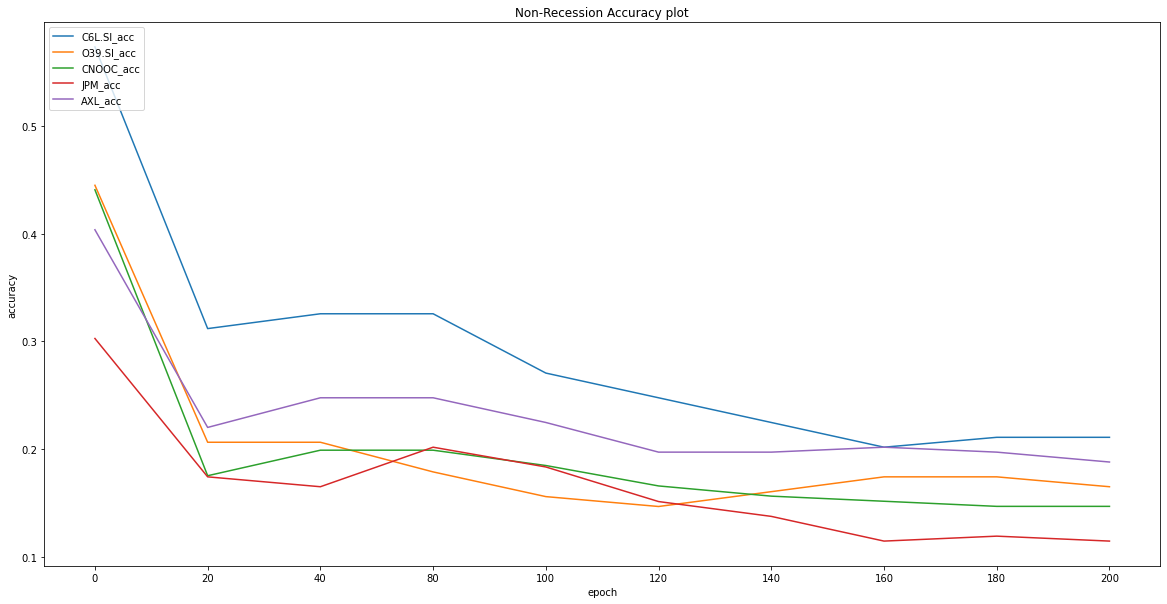

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(C6LSI_acc)
plt.plot(O39SI_acc)
plt.plot(CNOOC_acc)
plt.plot(JPM_acc)
plt.plot(AXL_acc)
plt.title('Non-Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['C6L.SI_acc','O39.SI_acc','CNOOC_acc','JPM_acc','AXL_acc'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'AXL_correct_buys')

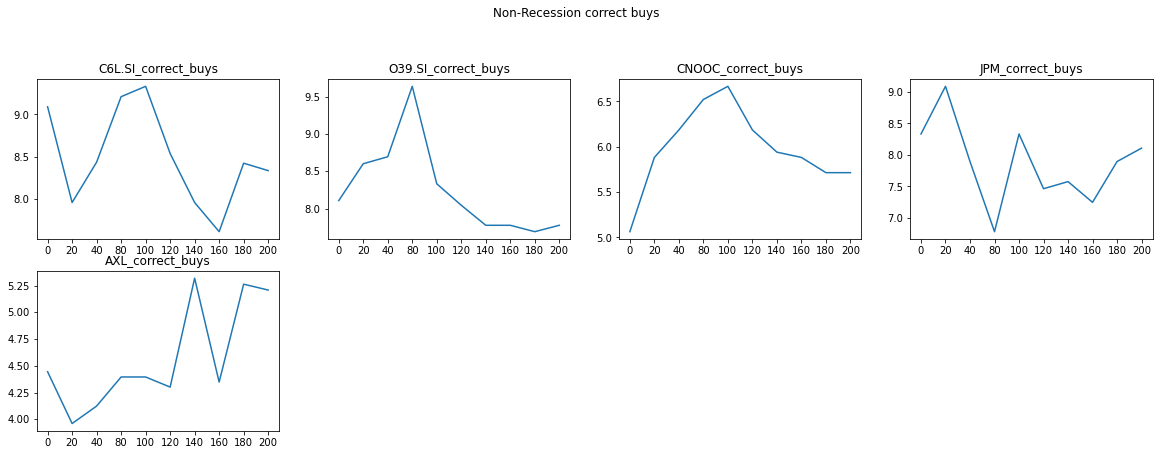

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct buys")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_buys")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_buys")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_buys")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_buys")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_buys")

Text(0.5, 1.0, 'AXL_correct_sells')

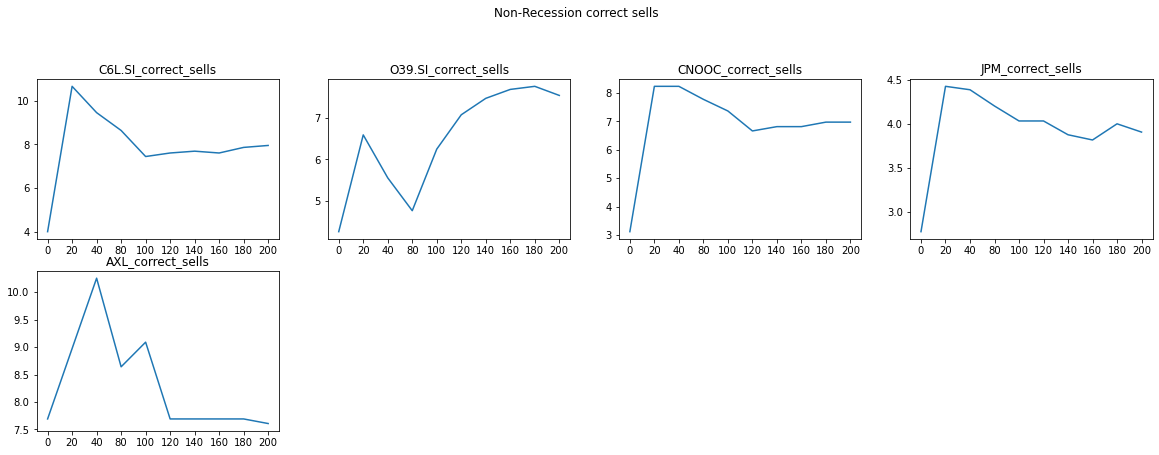

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct sells")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_sells")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_sells")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_sells")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_sells")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_sells")

Text(0.5, 1.0, 'AXL_correct_holds')

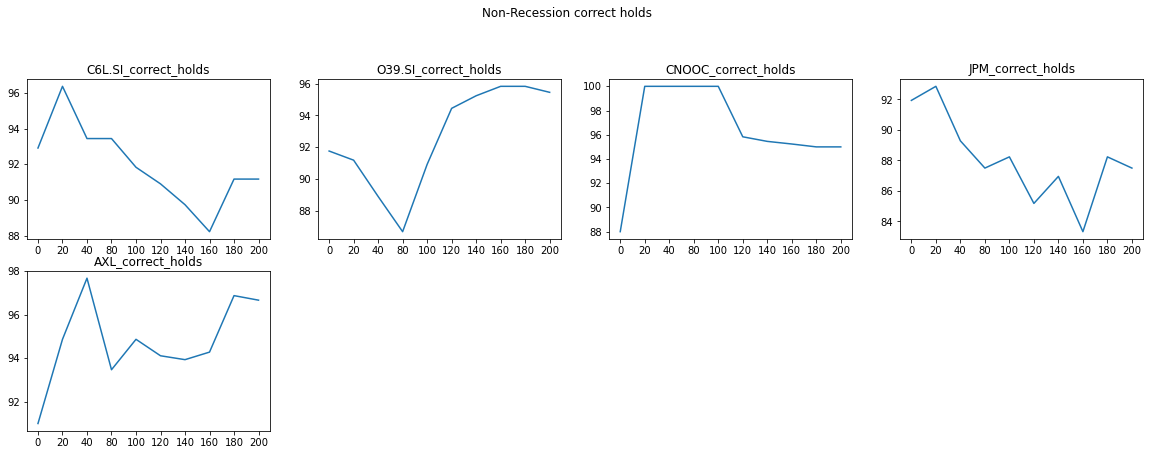

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct holds")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_holds")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_holds")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_holds")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_holds")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_holds")

Text(0.5, 1.0, 'AXL_correct_low_buys')

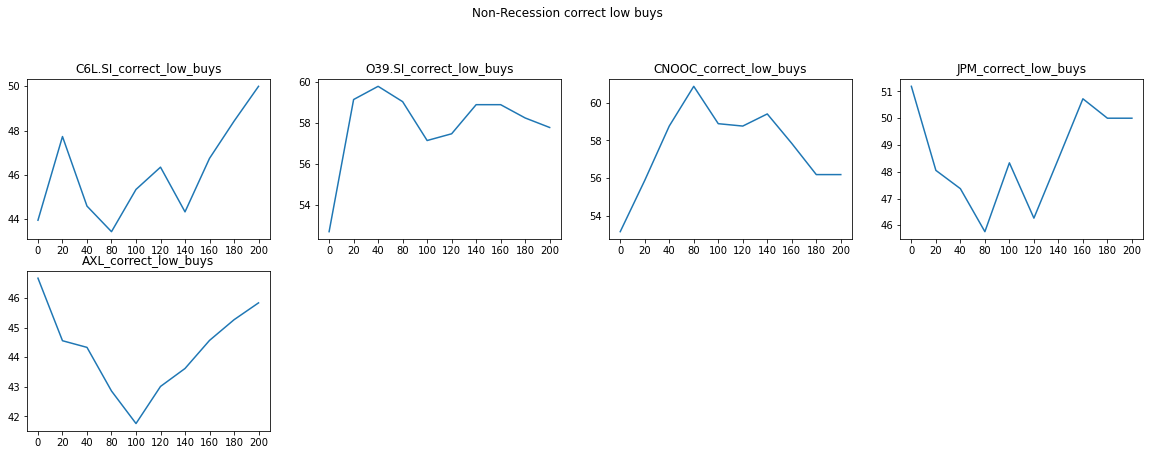

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct low buys")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_low_buys")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_low_buys")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_low_buys")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_low_buys")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_low_buys")

Text(0.5, 1.0, 'AXL_correct_high_sells')

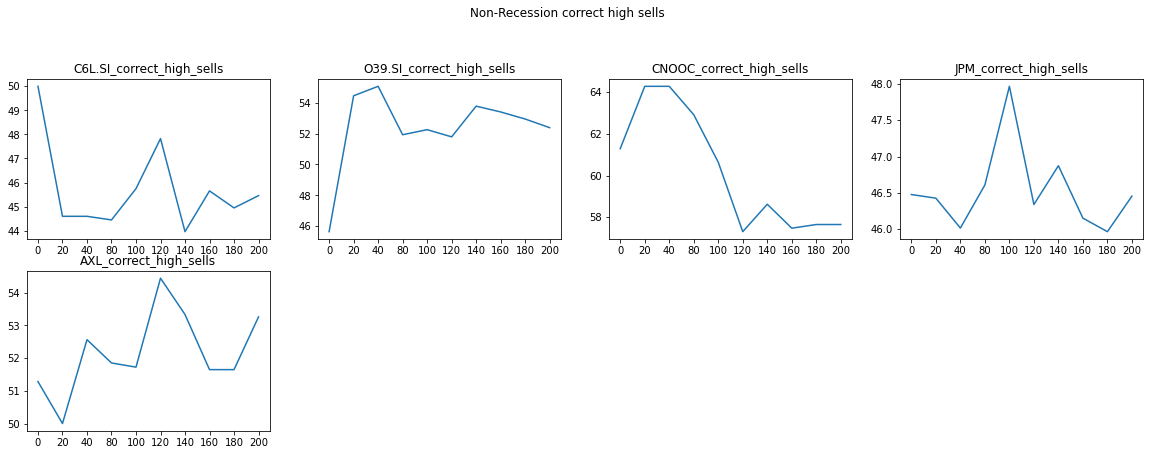

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct high sells")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_high_sells")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_high_sells")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_high_sells")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_high_sells")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_high_sells")

Text(0.5, 1.0, 'AXL_correct_mid_holds')

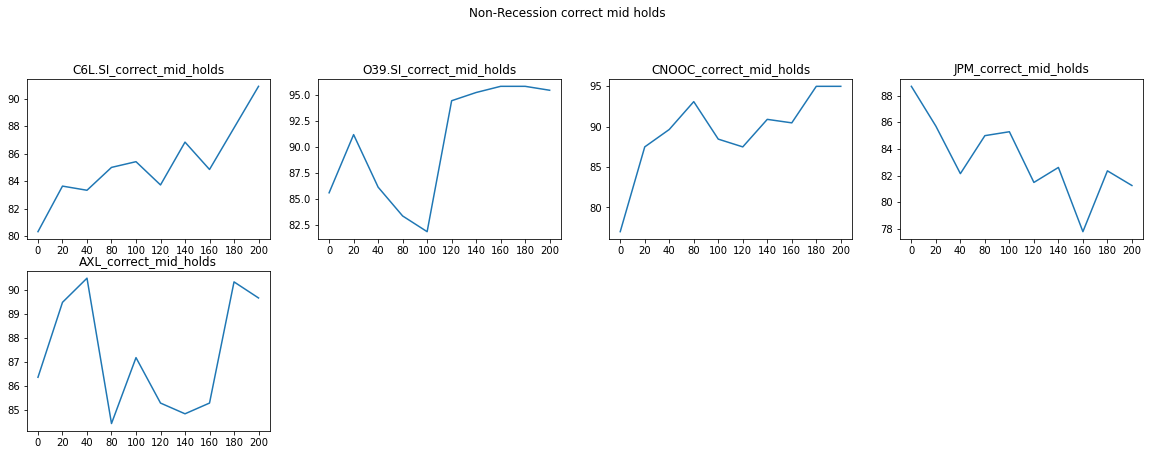

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct mid holds")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_mid_holds")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_mid_holds")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_mid_holds")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_mid_holds")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_mid_holds")

Text(0.5, 1.0, 'AXL_profit')

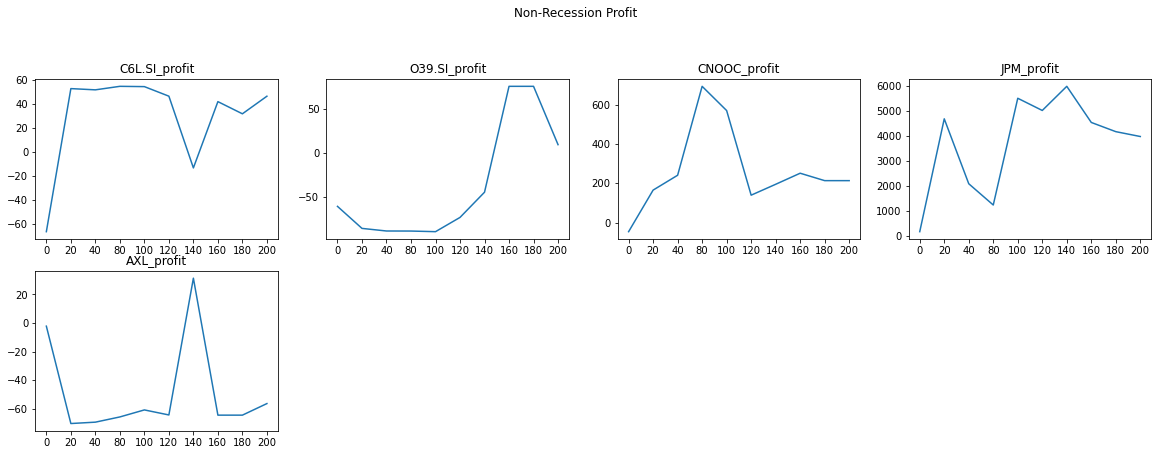

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Profit")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_profit")

plt.subplot(3, 4, 2)
plt.plot(O39SI_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_profit")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_profit")

plt.subplot(3, 4, 4)
plt.plot(JPM_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_profit")

plt.subplot(3, 4, 5)
plt.plot(AXL_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_profit")

In [30]:
C6LSI_acc = []
O39SI_acc = []
CNOOC_acc = []
JPM_acc = []
AXL_acc = []

C6LSI_correct_buys = []
O39SI_correct_buys = []
CNOOC_correct_buys = []
JPM_correct_buys = []
AXL_correct_buys = []

C6LSI_correct_sells = []
O39SI_correct_sells = []
CNOOC_correct_sells = []
JPM_correct_sells = []
AXL_correct_sells = []

C6LSI_correct_holds = []
O39SI_correct_holds = []
CNOOC_correct_holds = []
JPM_correct_holds = []
AXL_correct_holds = []

C6LSI_correct_low_buys = []
O39SI_correct_low_buys = []
CNOOC_correct_low_buys = []
JPM_correct_low_buys = []
AXL_correct_low_buys = []

C6LSI_correct_high_sells = []
O39SI_correct_high_sells = []
CNOOC_correct_high_sells = []
JPM_correct_high_sells = []
AXL_correct_high_sells = []

C6LSI_correct_mid_holds = []
O39SI_correct_mid_holds = []
CNOOC_correct_mid_holds = []
JPM_correct_mid_holds = []
AXL_correct_mid_holds = []

C6LSI_profit = []
O39SI_profit = []
CNOOC_profit = []
JPM_profit = []
AXL_profit = []

for key,value in r_log_hist.items():
    print(key)
    df = value
    acc = df['Test_accuracy'].values.tolist()
    correct_buys = df['correct_buys'].values.tolist()
    correct_sells = df['correct_sells'].values.tolist()
    correct_holds = df['correct_holds'].values.tolist()
    correct_low_buys = df['correct_low_buys'].values.tolist()
    correct_high_sells = df['correct_high_sells'].values.tolist()
    correct_mid_holds = df['correct_mid_holds'].values.tolist()
    profit = df['Profit gained'].values.tolist()
    
    C6LSI_acc.append(acc[0])
    O39SI_acc.append(acc[1])
    CNOOC_acc.append(acc[2])
    JPM_acc.append(acc[3]) 
    AXL_acc.append(acc[4]) 

    C6LSI_correct_buys.append(correct_buys[0])
    O39SI_correct_buys.append(correct_buys[1]) 
    CNOOC_correct_buys.append(correct_buys[2]) 
    JPM_correct_buys.append(correct_buys[3]) 
    AXL_correct_buys.append(correct_buys[4])
    

    C6LSI_correct_sells.append(correct_sells[0]) 
    O39SI_correct_sells.append(correct_sells[1]) 
    CNOOC_correct_sells.append(correct_sells[2]) 
    JPM_correct_sells.append(correct_sells[3]) 
    AXL_correct_sells.append(correct_sells[4]) 
    

    C6LSI_correct_holds.append(correct_holds[0]) 
    O39SI_correct_holds.append(correct_holds[1])  
    CNOOC_correct_holds.append(correct_holds[2])  
    JPM_correct_holds.append(correct_holds[3])  
    AXL_correct_holds.append(correct_holds[4])  
     

    C6LSI_correct_low_buys.append(correct_low_buys[0])  
    O39SI_correct_low_buys.append(correct_low_buys[1])  
    CNOOC_correct_low_buys.append(correct_low_buys[2])  
    JPM_correct_low_buys.append(correct_low_buys[3])   
    AXL_correct_low_buys.append(correct_low_buys[4])   
    

    C6LSI_correct_high_sells.append(correct_high_sells[0]) 
    O39SI_correct_high_sells.append(correct_high_sells[1]) 
    CNOOC_correct_high_sells.append(correct_high_sells[2]) 
    JPM_correct_high_sells.append(correct_high_sells[3]) 
    AXL_correct_high_sells.append(correct_high_sells[4]) 
    

    C6LSI_correct_mid_holds.append(correct_mid_holds[0])  
    O39SI_correct_mid_holds.append(correct_mid_holds[1])  
    CNOOC_correct_mid_holds.append(correct_mid_holds[2])   
    JPM_correct_mid_holds.append(correct_mid_holds[3])   
    AXL_correct_mid_holds.append(correct_mid_holds[4])   
    

    C6LSI_profit.append(profit[0]) 
    O39SI_profit.append(profit[1]) 
    CNOOC_profit.append(profit[2]) 
    JPM_profit.append(profit[3])  
    AXL_profit.append(profit[4])  

0_epochs_logs
20_epochs_logs
40_epochs_logs
60_epochs_logs
80_epochs_logs
100_epochs_logs
120_epochs_logs
140_epochs_logs
160_epochs_logs
180_epochs_logs


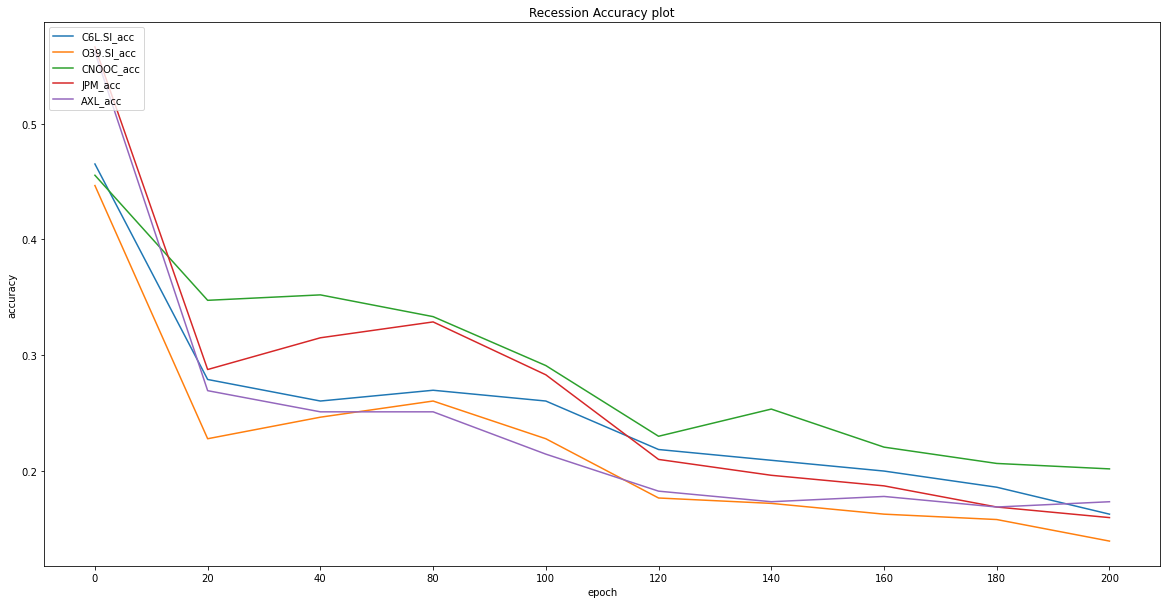

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(C6LSI_acc)
plt.plot(O39SI_acc)
plt.plot(CNOOC_acc)
plt.plot(JPM_acc)
plt.plot(AXL_acc)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['C6L.SI_acc','O39.SI_acc','CNOOC_acc','JPM_acc','AXL_acc'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'AXL_correct_buys')

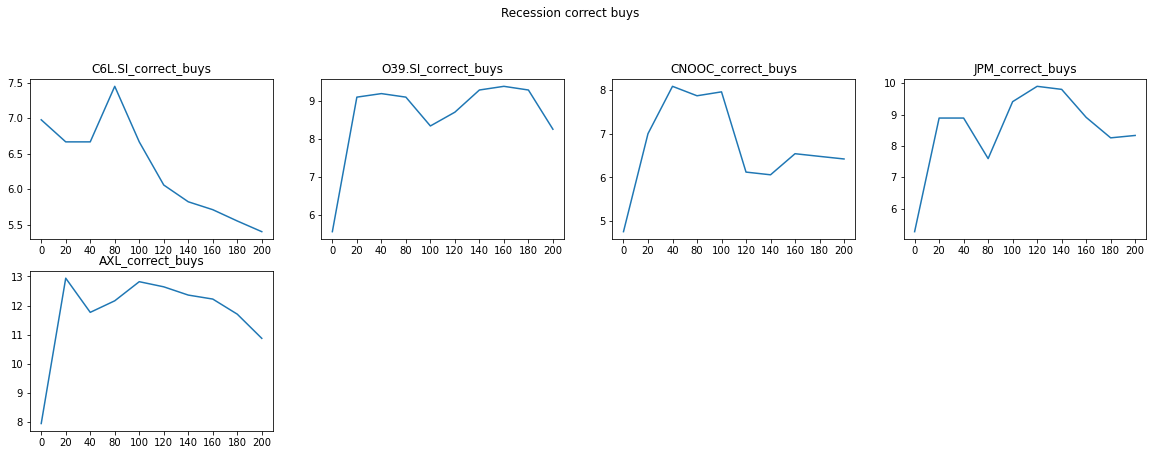

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct buys")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_buys")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_buys")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_buys")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_buys")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_buys")

Text(0.5, 1.0, 'AXL_correct_sells')

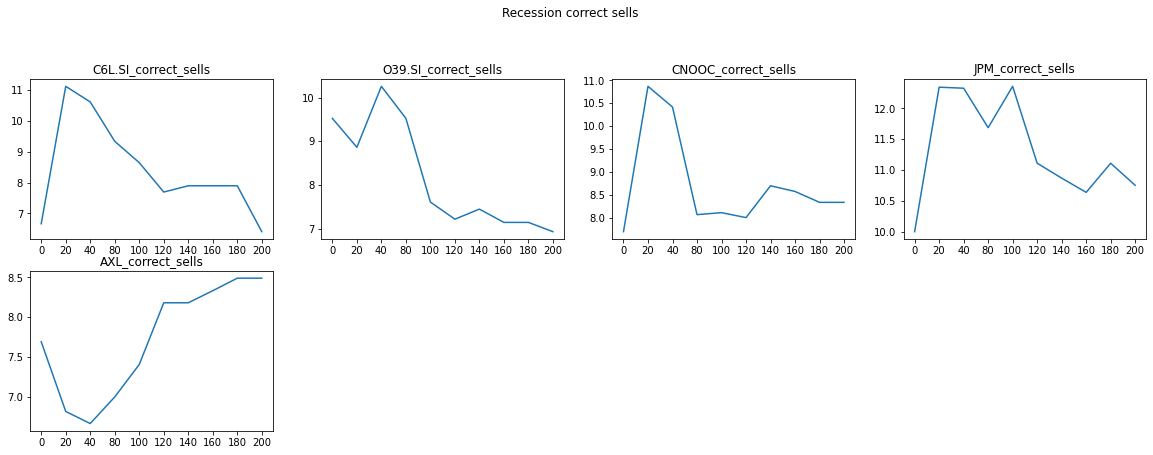

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct sells")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_sells")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_sells")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_sells")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_sells")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_sells")

Text(0.5, 1.0, 'AXL_correct_holds')

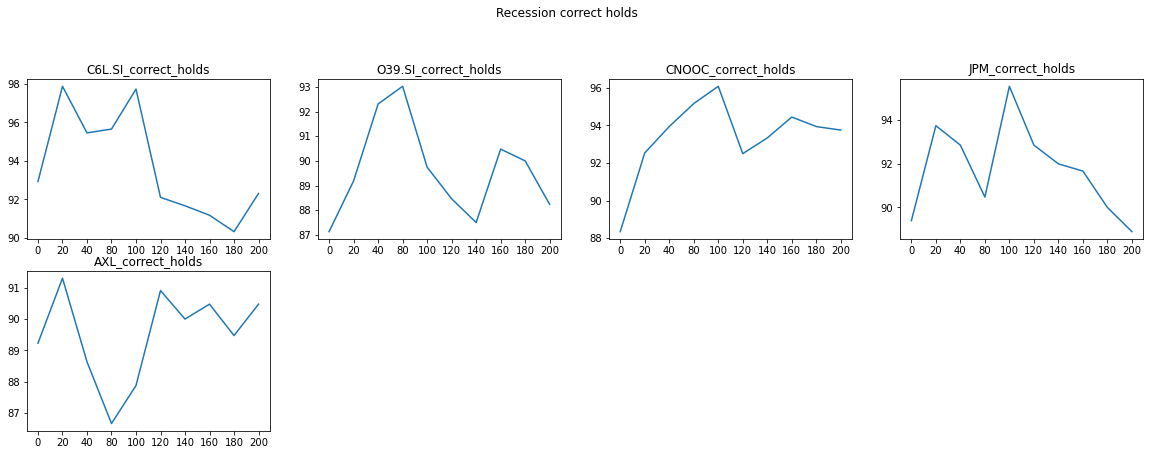

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct holds")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_holds")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_holds")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_holds")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_holds")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_holds")

Text(0.5, 1.0, 'AXL_correct_low_buys')

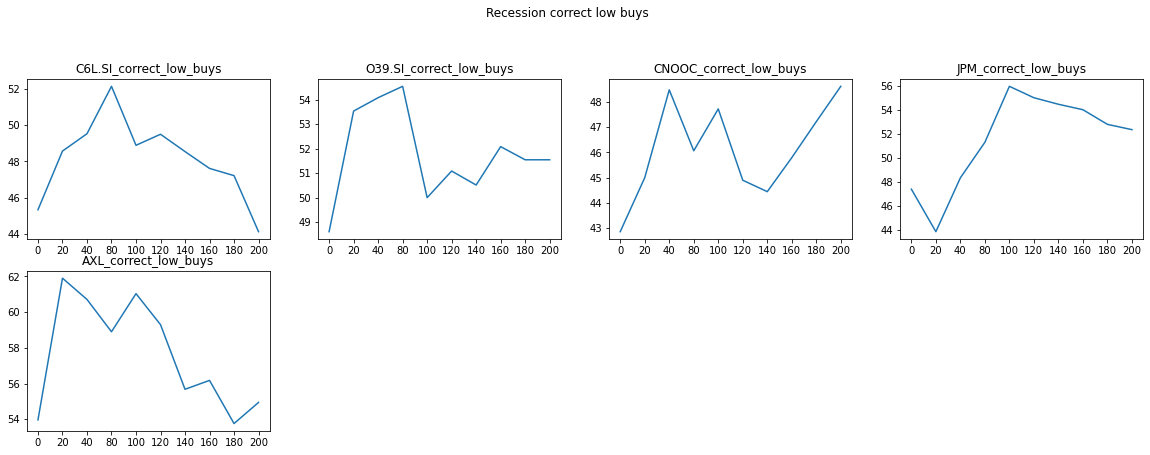

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct low buys")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_low_buys")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_low_buys")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_low_buys")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_low_buys")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_low_buys")

Text(0.5, 1.0, 'AXL_correct_high_sells')

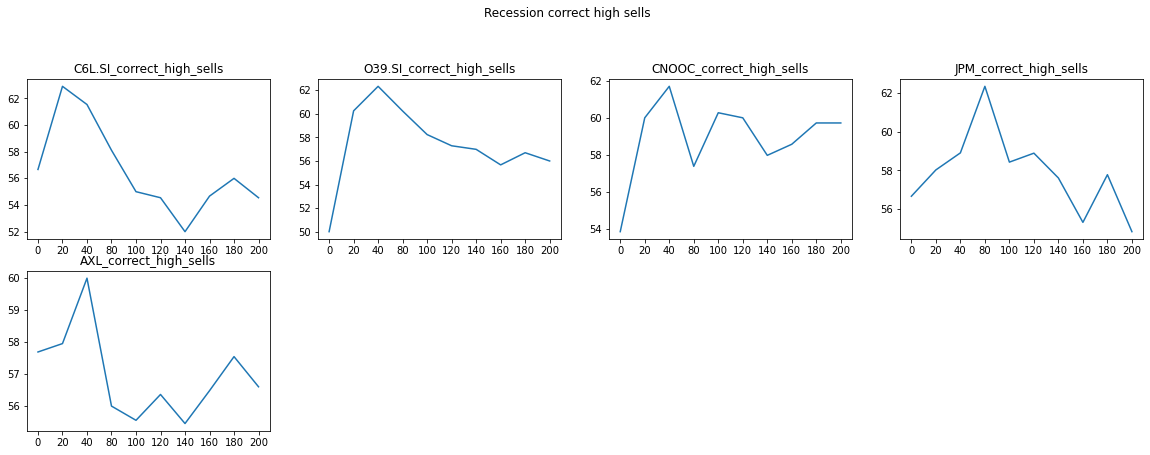

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct high sells")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_high_sells")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_high_sells")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_high_sells")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_high_sells")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_high_sells")

Text(0.5, 1.0, 'AXL_correct_mid_holds')

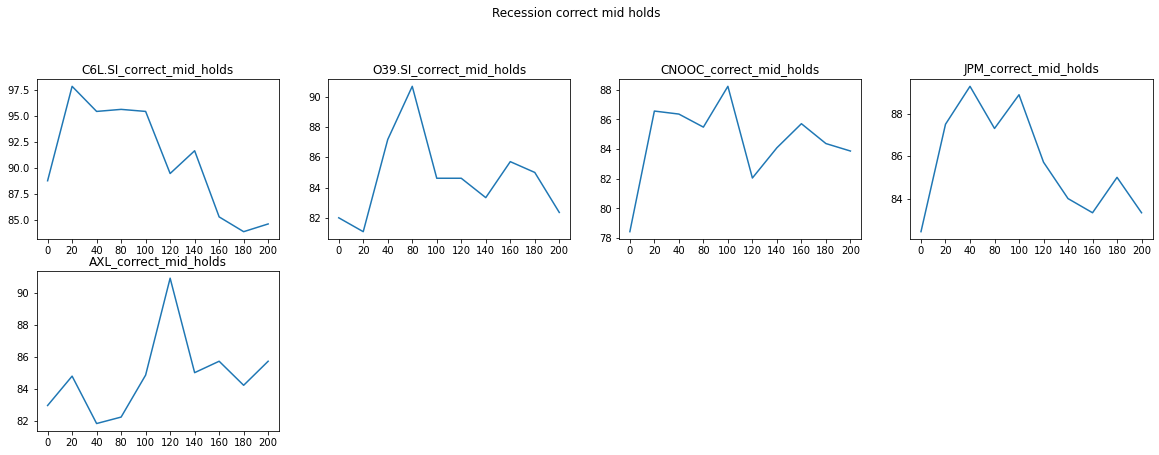

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct mid holds")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_mid_holds")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_mid_holds")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_mid_holds")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_mid_holds")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_mid_holds")

Text(0.5, 1.0, 'AXL_profit')

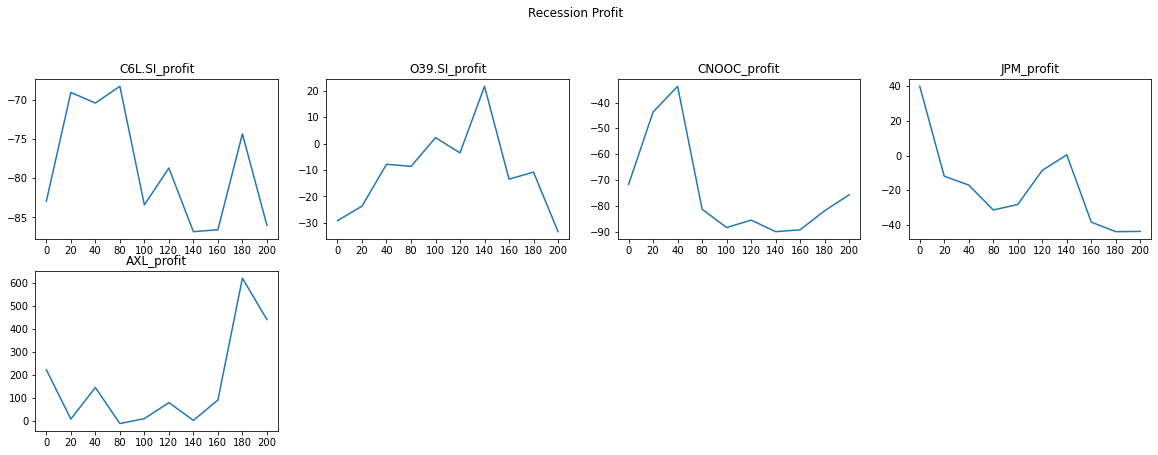

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Profit")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_profit")

plt.subplot(3, 4, 2)
plt.plot(O39SI_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_profit")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_profit")

plt.subplot(3, 4, 4)
plt.plot(JPM_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_profit")

plt.subplot(3, 4, 5)
plt.plot(AXL_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_profit")